# Data Provider
Abstract class that provides a skeleton for any class that implements providing data batches to RBM.

In [1]:
class DataProvider(object):
    """
        Implements the data provider for RBM. Abstract class.
    """
    
    def __init__(self, input_dim, batch_size):
        """
            __init__(DataProvider, int, int) -> None
            input_dim: The dimensionality of visible layer
            batch_size: Number of examples in a batch
        """
        self.input_dim = input_dim
        self.batch_size = batch_size
        
        
    def get_input_dim(self):
        """
            get_input_dim(DataProvider) -> int
            Returns: The dimensionality of the input
        """
        return self.input_dim
        
        
    def get_batch_size(self):
        """
            get_batch_size(DataProvider) -> int
            Returns: The number of examples in a batch
        """
        return self.batch_size
        
        
    def get_batch(self, set_type='train'):
        """
            get_batch(DataProvider, str) -> ndarray
            set_type: 'train', 'test' or 'val'
            Returns: batch_size x input_dim binary array containing data
        """
        pass

# MNIST Data Provider
Subclass of DataProvider that provides MNIST data to RBM.

In [2]:
import numpy as np
import gzip
import struct
import os

class MNIST(DataProvider):
    def __init__(self, data_dir, batch_size, train_frac=0.7, seed=None):
        """
            __init__(MNIST, str, int, float, int) -> None
            data_dir: Root directory containing the mnist zip files
            batch_size: Number of examples per batch
            train_frac: Fraction of training data to be used for training
            seed: Seed for randomly loading and selecting data
            
            Reads the MNIST dataset for RBM
        """
        self.data_dir = data_dir
        if seed is not None:
            np.random.seed(seed)
        self.train_frac = train_frac
        self.set_size = dict()  # Contains number of examples for different sets
        self.dataset = dict()   # Contains actual data
        self.read_data()    # Read the data
        DataProvider.__init__(self, 784, batch_size)
        
        
    def read_data(self):
        """
            read_data(MNIST) -> None
            Reads the data from the data directory
        """
        train_file_name = 'train-images-idx3-ubyte.gz'
        test_file_name = 't10k-images-idx3-ubyte.gz'
        
        # Extract the training data
        with gzip.open(os.path.join(self.data_dir, train_file_name), 'rb') as f:
            content = f.read()
            with open(os.path.join(self.data_dir, train_file_name[:-3]), 'wb') as f1:
                f1.write(content)
        
        # Read the training and validation data
        data = self.read_idx(os.path.join(self.data_dir, train_file_name[:-3]))
        np.random.shuffle(data)
        data = data.reshape((-1, 784))
        self.dataset['train'] = data[:int(data.shape[0]*self.train_frac), :]
        self.dataset['val'] = data[int(data.shape[0]*self.train_frac):, :]
        self.set_size['train'] = self.dataset['train'].shape[0]
        self.set_size['val'] = self.dataset['val'].shape[0]
        
        # Delete the training data file
        os.remove(os.path.join(self.data_dir, train_file_name[:-3]))
        
        # Extract the test data
        with gzip.open(os.path.join(self.data_dir, test_file_name), 'rb') as f:
            content = f.read()
            with open(os.path.join(self.data_dir, test_file_name[:-3]), 'wb') as f1:
                f1.write(content)
        
        # Read the test data
        data = self.read_idx(os.path.join(self.data_dir, test_file_name[:-3]))
        np.random.shuffle(data)
        data = data.reshape((-1, 784))
        self.dataset['test'] = data
        self.set_size['test'] = self.dataset['test'].shape[0]
                
        # Delete the test data file
        os.remove(os.path.join(self.data_dir, test_file_name[:-3]))
    
    
    def read_idx(self, filename):
        """
            read_idx(MNIST, str) -> ndarray
            Reads the idx file into a numpy array.
            
            Taken from: 
            https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40
        """
        with open(filename, 'rb') as f:
            zero, data_type, dims = struct.unpack('>HBB', f.read(4))
            shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
            return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
    def get_batch(self, set_type='train'):
        """
            get_batch(MNIST, str) -> ndarray
            set_type: 'train', 'test' or 'val'
            Returns: batch_size x input_dim binary array containing data
        """
        idx = np.random.choice(self.set_size[set_type], size=self.batch_size, \
                                replace=False)
        data = self.dataset[set_type][idx, :]
        return (data >= 128).astype(np.float32)
        
    
    def get_set_size(self, set_type='train'):
        """
            get_set_size(MNIST, str) -> int
            Returns the number of examples in the current set
        """
        return self.set_size[set_type]

# Restricted Boltzmann Machine

In [3]:
import numpy as np

class RBM(object):
    """
        Implements a Restricted Boltzmann Machine
    """
    
    def __init__(self, data_provider, num_hidden, learning_rate=1e-3):
        """
            __init__(RBM, DataProvider, int, float) -> None
            data_provider: Instance of class that provides data in the right 
                           format.
            learning_rate: Learning rate used while training
            num_hidden: Number of hidden units to be used
        """
        self.num_hidden = num_hidden
        self.data = data_provider
        self.learning_rate = learning_rate
        self.batch_size = self.data.get_batch_size()
        self.num_visible = self.data.get_input_dim()
        self.w = np.random.normal(size=(self.num_visible, self.num_hidden), scale=0.1)
        self.b = np.zeros((self.num_visible, 1))
        self.c = np.zeros((self.num_hidden, 1))
        
    
    def sample(self, v=None, h=None, num_iters=100):
        """
            sample(RBM, ndarray, ndarray, int) -> (ndarray, ndarray)
            Generates a sample (v, h) from the RBM
            v: Length num_visible binary ndarray containing initial value of visible units
            h: Length num_hidden binary ndarray containing initial value of hidden units
            num_iters: Number of iterations for which Gibbs Sampler should be run
            Returns:
                A sample (v, h) pair
        """
        # Decide which vector to sample first
        sample_visible = True
        if h is None and v is not None:
            sample_visible = False
        
        # If initial values are not specified then randomly initialize them
        if v is None:
            v = np.random.randint(low=0, high=2, size=(self.num_visible, 1)).astype(np.float32)
        if h is None:
            h = np.random.randint(low=0, high=2, size=(self.num_hidden, 1)).astype(np.float32)
            
        # Sample
        for i in range(2*num_iters):
            if sample_visible:
                v = np.random.binomial(1, self.prob_v_given_h(h)).astype(np.float32)
            else:
                h = np.random.binomial(1, self.prob_h_given_v(v)).astype(np.float32)
            sample_visible = not sample_visible
        
        return (v, h)
        
    
    def prob_v_given_h(self, h):
        """
            prob_v_given_h(RBM, ndarray) -> ndarray
            Calculates the probability P(v|h) for the given value of h
            h: Length num_hidden binary ndarray containing the current value of hidden units
            Returns:
                A num_visible length ndarray containing P(v|h)
        """
        return self.sigmoid(np.matmul(self.w, h) + self.b) 
        
        
        
    def prob_h_given_v(self, v):
        """
            prob_h_given_v(RBM, ndarray) -> ndarray
            Calculates the probability P(h|v) for the given value of v
            v: Length num_visible binary ndarray containing the current value of visible units
            Returns:
                A num_hidden length ndarray containing P(h|v)
        """
        return self.sigmoid(np.matmul(v.transpose(), self.w) + self.c.transpose()).transpose()
        

    def sigmoid(self, x):
        """
            sigmoid(RBM, ndarray) -> ndarray
            Returns sigmoid function evaluated for argument x
        """
        return 1 / (1 + np.exp(-x))
    
    
    def train(self, num_iters_gibbs=100, num_iters_exp=100):
        """
            train(RBM, ndarray, int, int) -> None
            Trains the RBM on a single batch.
            num_iters_gibbs: Number of iterations to be used in gibbs sampler
            num_iters_expt: Number of terms to be sampled to approximate expectation
        """
        # Get the batch
        v = self.data.get_batch().transpose() # num_visible x batch_size
        
        # Calculate P(Z|X)
        ph_v = self.prob_h_given_v(v).transpose() # batch_size x num_hidden
        
        # Calculate various expectation terms that are required
        # Evh = num_visible x num_hidden
        # Ev = num_visible x 1
        # Eh = num_hidden x 1
        Evh, Ev, Eh = self.calc_exp_model(num_iters_gibbs, num_iters_exp)
        
        # Calculate grad_w
        temp = np.zeros(shape=(self.num_visible, self.num_hidden))
        for i in range(self.batch_size):
            temp += np.matmul(np.expand_dims(v[:, i], axis=1), np.expand_dims(ph_v[i, :], axis=0))
        grad_w = -temp + self.batch_size * Evh
        
        # Calculate grad_b
        grad_b = -np.expand_dims(np.sum(v, axis=1), axis=1) + self.batch_size * Ev
        
        # Calculate grad_c
        grad_c = -np.expand_dims(np.sum(ph_v, axis=0), axis=1) + self.batch_size * Eh
        
        # Update the weights
        self.w = self.w - self.learning_rate * grad_w
        self.b = self.b - self.learning_rate * grad_b
        self.c = self.c - self.learning_rate * grad_c
        
        

    def calc_exp_model(self, num_iters_gibbs=100, num_iters_exp=100):
        """
            calc_exp_model(RBM, int, int) -> ndarray
            Calculates E[v_k * h_l] under the joint P(v, h) defined by this RBM
            num_iters_gibbs: Number of iterations to be used in gibbs sampler
            num_iters_expt: Number of terms to be sampled to approximate expectation
            Returns:
                (E[v_k * h_l], E[v_k], E[h_l])
        """
        Evh = np.zeros(shape=(self.num_visible, self.num_hidden))
        Ev = np.zeros(shape=(self.num_visible, 1))
        Eh = np.zeros(shape=(self.num_hidden, 1))
        
        for i in range(num_iters_exp):
            v, h = self.sample(num_iters = num_iters_gibbs)
            v1, h1 = self.sample(num_iters = num_iters_gibbs)
            Evh += (v * h.transpose()) + (v1 * h1.transpose())
            Ev += v
            Eh += h
        
        Evh = Evh / (2*num_iters_exp)
        Ev = Ev / num_iters_exp
        Eh = Eh / num_iters_exp
        return (Evh, Ev, Eh)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

mnist = MNIST('../../Datasets/mnist', 128)
rbm = RBM(mnist, num_hidden=500)

In [ ]:
for i in range(1000):
    print 'Starting batch:', i+1
    rbm.train(num_iters_gibbs=100, num_iters_exp=10)
    print 'Trained batch:', i+1
    v, h = rbm.sample(num_iters=100)
    v_argmax = (rbm.prob_v_given_h(h) >= 0.5).astype(np.float32)
    plt.imshow(np.concatenate([v.reshape((28, 28)), v_argmax.reshape((28, 28))], axis=1))
    plt.show()

In [ ]:
images = mnist.get_batch()

In [ ]:
idx = 20
v = images[idx, :].transpose()
h = rbm.prob_h_given_v(v)
h = np.random.binomial(1, p=h).astype(np.float32)
v_recon = rbm.prob_v_given_h(h)
v_recon = np.random.binomial(1, v_recon).astype(np.float32)
v_recon, _ = rbm.sample(h=h)
plt.imshow(np.concatenate([v.reshape((28, 28)), v_recon.reshape((28, 28))], axis=1))
plt.figure()
plt.imshow(h.reshape((10, 10)))

In [ ]:
plt.imshow(rbm.b.reshape((28, 28)))

In [144]:
import numpy as np

class RBMPersistent(RBM):
    """
        Implements a Restricted Boltzmann Machine with a persistent gibbs chain
    """
    
    def __init__(self, data_provider, num_hidden, learning_rate=1e-3):
        """
            __init__(RBMPersistent, DataProvider, int, float) -> None
            data_provider: Instance of class that provides data in the right 
                           format.
            learning_rate: Learning rate used while training
            num_hidden: Number of hidden units to be used
        """
        RBM.__init__(self, data_provider, num_hidden, learning_rate)
    
    
    def train(self, num_iters_gibbs=100, num_iters_exp=100):
        """
            train(RBMPersistent, ndarray, int, int) -> None
            Trains the RBM on a single batch.
            num_iters_gibbs: Number of iterations to be used in gibbs sampler
            num_iters_expt: Number of terms to be sampled to approximate expectation
        """
        # Get the batch
        v = self.data.get_batch().transpose() # num_visible x batch_size
        
        # Calculate P(Z|X)
        ph_v = self.prob_h_given_v(v).transpose() # batch_size x num_hidden
        
        # Calculate various expectation terms that are required
        # Evh = num_visible x num_hidden
        # Ev = num_visible x 1
        # Eh = num_hidden x 1
        Evh, Ev, Eh = self.calc_exp_model(num_iters_gibbs, num_iters_exp)
        
        # Calculate grad_w
        temp = np.zeros(shape=(self.num_visible, self.num_hidden))
        for i in range(self.batch_size):
            temp += np.matmul(np.expand_dims(v[:, i], axis=1), np.expand_dims(ph_v[i, :], axis=0))
        grad_w = temp - self.batch_size * Evh
        
        # Calculate grad_b
        grad_b = np.expand_dims(np.sum(v, axis=1), axis=1) - self.batch_size * Ev
        
        # Calculate grad_c
        grad_c = np.expand_dims(np.sum(ph_v, axis=0), axis=1) - self.batch_size * Eh
        
        # Update the weights
        self.w = self.w + self.learning_rate * grad_w
        self.b = self.b + self.learning_rate * grad_b
        self.c = self.c + self.learning_rate * grad_c
        
        

    def calc_exp_model(self, num_iters_gibbs=100, num_iters_exp=100):
        """
            calc_exp_model(RBMPersistent, int, int) -> ndarray
            Calculates E[v_k * h_l] under the joint P(v, h) defined by this RBM
            num_iters_gibbs: Number of iterations to be used in gibbs sampler
            num_iters_expt: Number of terms to be sampled to approximate expectation
            Returns:
                (E[v_k * h_l], E[v_k], E[h_l])
        """
        Evh = np.zeros(shape=(self.num_visible, self.num_hidden))
        Ev = np.zeros(shape=(self.num_visible, 1))
        Eh = np.zeros(shape=(self.num_hidden, 1))
        
        images = self.data.get_batch()
        for i in range(num_iters_exp):
            v = images[np.random.randint(0, self.batch_size), :].reshape((-1, 1))
            v, h = self.sample(v=v, num_iters=num_iters_gibbs)
            Evh += np.matmul(v, h.transpose())
            Ev += v
            Eh += h
        
        Evh = Evh / num_iters_exp
        Ev = Ev / num_iters_exp
        Eh = Eh / num_iters_exp
        return (Evh, Ev, Eh)

In [151]:
import matplotlib.pyplot as plt
%matplotlib inline

mnist_persistent = MNIST('../../Datasets/mnist', 128)
rbm_persistent = RBMPersistent(mnist_persistent, num_hidden=500, learning_rate=1e-4)

Starting batch: 1
Trained batch: 1


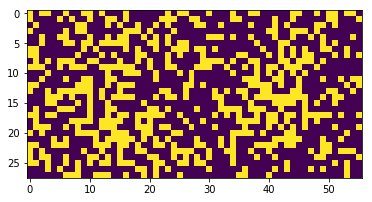

Starting batch: 2
Trained batch: 2


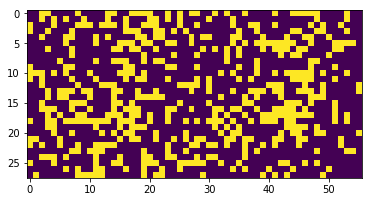

Starting batch: 3
Trained batch: 3


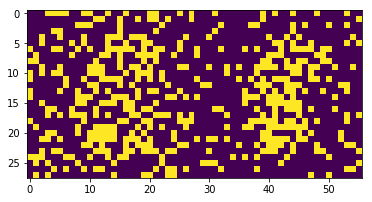

Starting batch: 4
Trained batch: 4


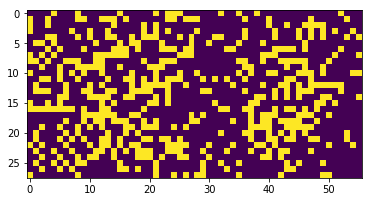

Starting batch: 5
Trained batch: 5


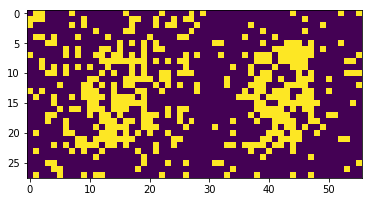

Starting batch: 6
Trained batch: 6


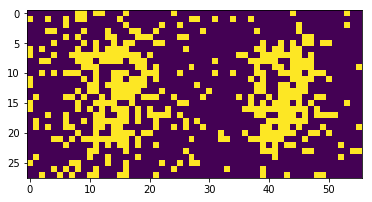

Starting batch: 7
Trained batch: 7


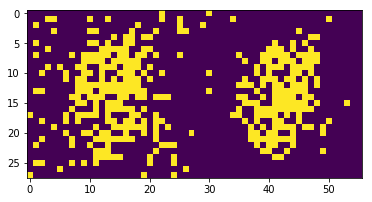

Starting batch: 8
Trained batch: 8


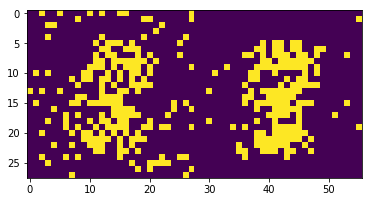

Starting batch: 9
Trained batch: 9


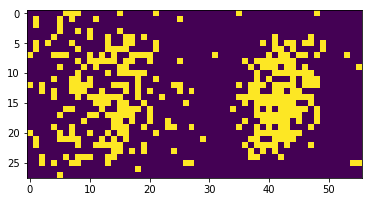

Starting batch: 10
Trained batch: 10


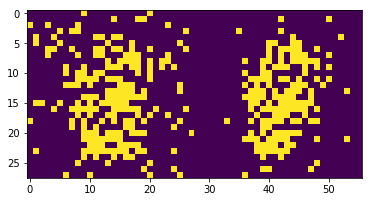

Starting batch: 11
Trained batch: 11


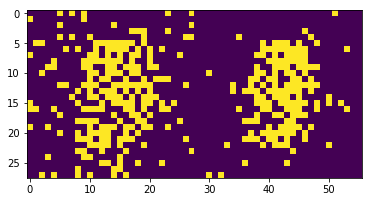

Starting batch: 12
Trained batch: 12


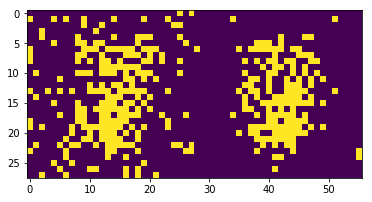

Starting batch: 13
Trained batch: 13


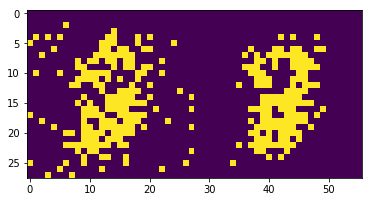

Starting batch: 14
Trained batch: 14


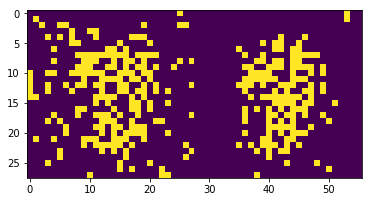

Starting batch: 15
Trained batch: 15


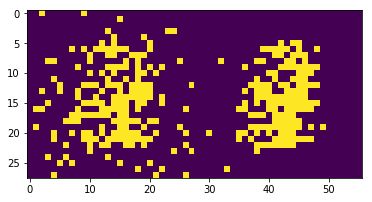

Starting batch: 16
Trained batch: 16


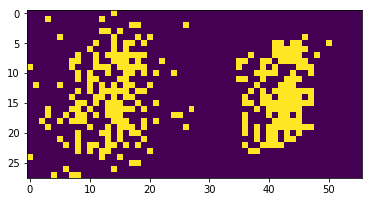

Starting batch: 17
Trained batch: 17


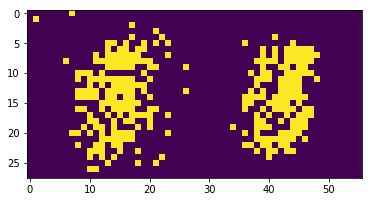

Starting batch: 18
Trained batch: 18


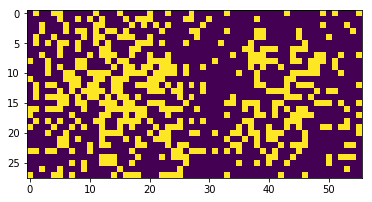

Starting batch: 19
Trained batch: 19


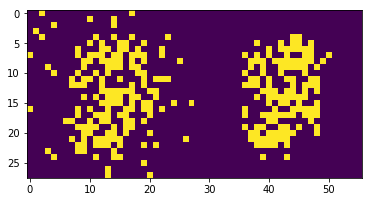

Starting batch: 20
Trained batch: 20


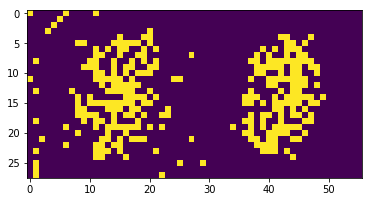

Starting batch: 21
Trained batch: 21


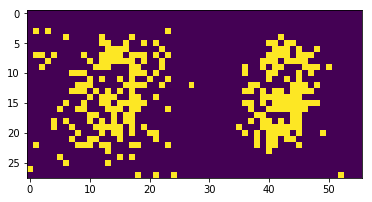

Starting batch: 22
Trained batch: 22


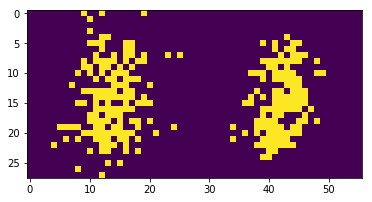

Starting batch: 23
Trained batch: 23


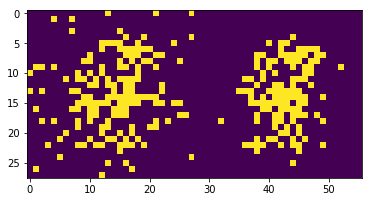

Starting batch: 24
Trained batch: 24


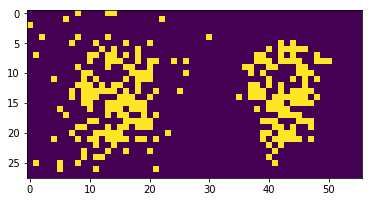

Starting batch: 25
Trained batch: 25


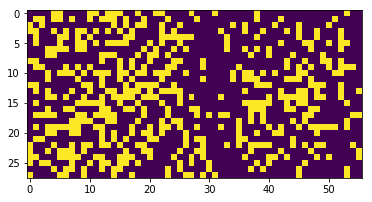

Starting batch: 26
Trained batch: 26


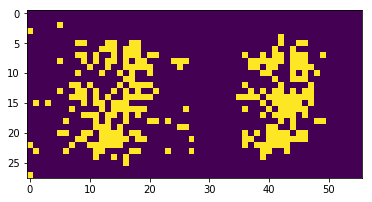

Starting batch: 27
Trained batch: 27


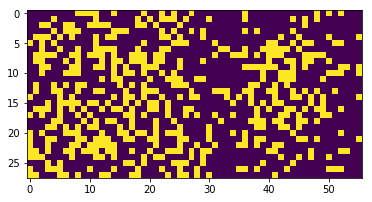

Starting batch: 28
Trained batch: 28


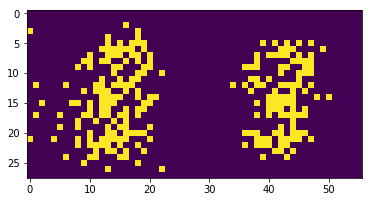

Starting batch: 29
Trained batch: 29


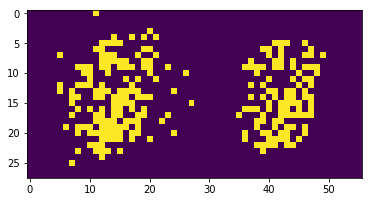

Starting batch: 30
Trained batch: 30


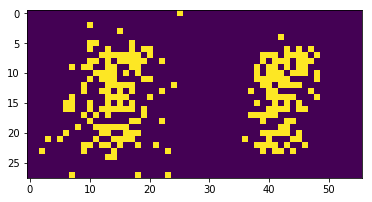

Starting batch: 31
Trained batch: 31


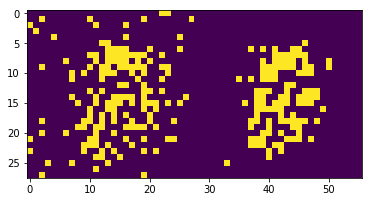

Starting batch: 32
Trained batch: 32


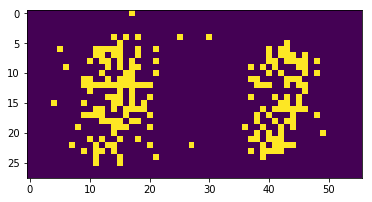

Starting batch: 33
Trained batch: 33


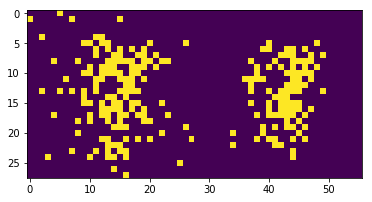

Starting batch: 34
Trained batch: 34


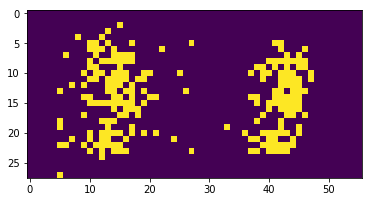

Starting batch: 35
Trained batch: 35


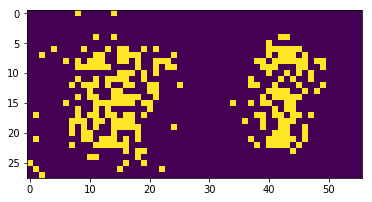

Starting batch: 36
Trained batch: 36


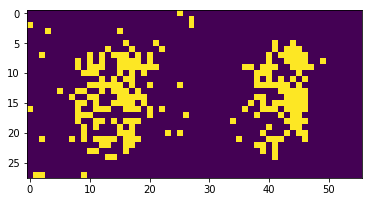

Starting batch: 37
Trained batch: 37


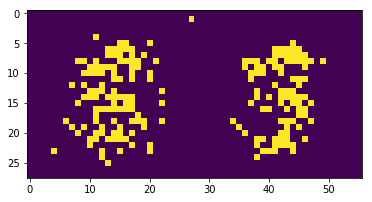

Starting batch: 38
Trained batch: 38


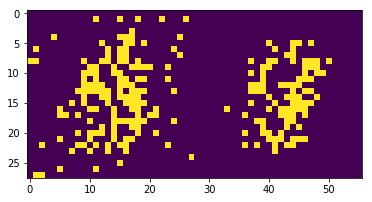

Starting batch: 39
Trained batch: 39


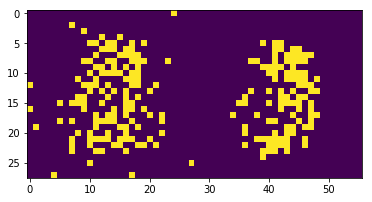

Starting batch: 40
Trained batch: 40


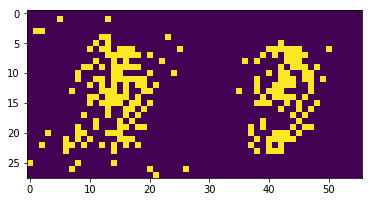

Starting batch: 41
Trained batch: 41


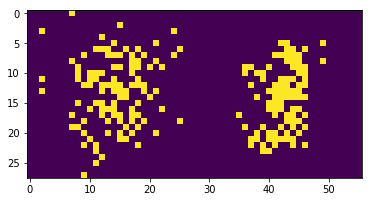

Starting batch: 42
Trained batch: 42


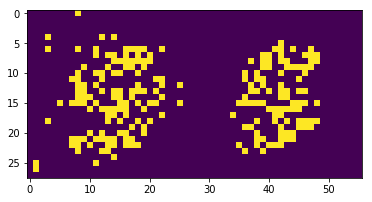

Starting batch: 43
Trained batch: 43


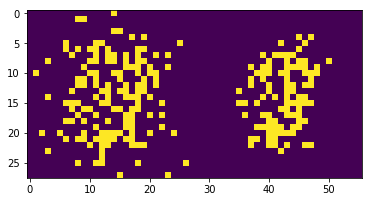

Starting batch: 44
Trained batch: 44


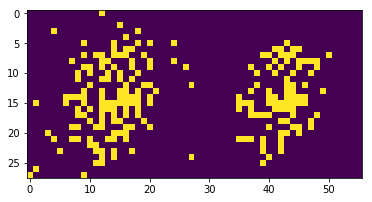

Starting batch: 45
Trained batch: 45


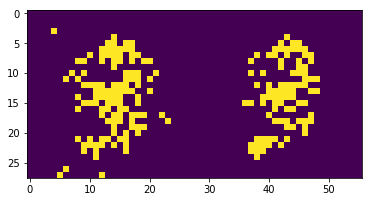

Starting batch: 46
Trained batch: 46


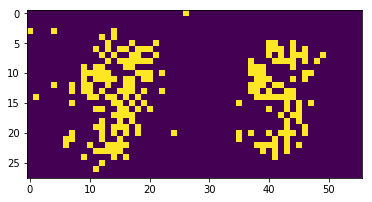

Starting batch: 47
Trained batch: 47


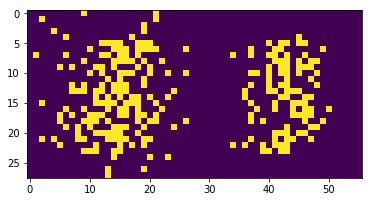

Starting batch: 48
Trained batch: 48


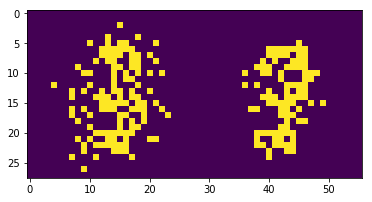

Starting batch: 49
Trained batch: 49


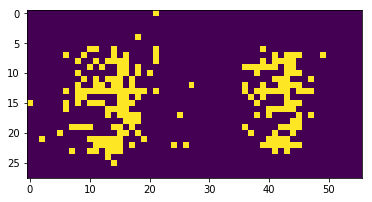

Starting batch: 50
Trained batch: 50


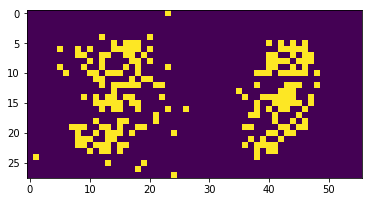

Starting batch: 51
Trained batch: 51


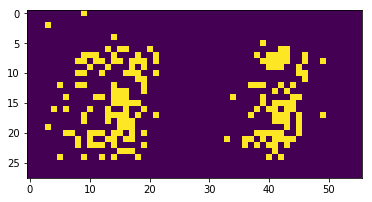

Starting batch: 52
Trained batch: 52


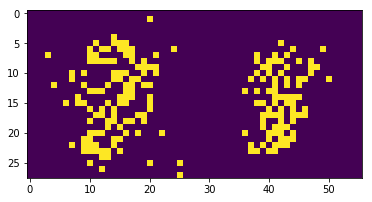

Starting batch: 53
Trained batch: 53


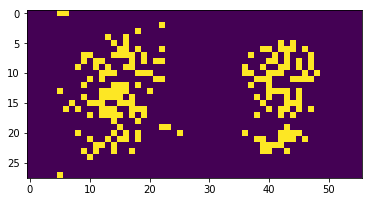

Starting batch: 54
Trained batch: 54


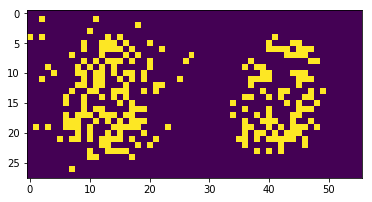

Starting batch: 55
Trained batch: 55


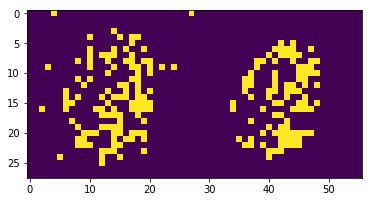

Starting batch: 56
Trained batch: 56


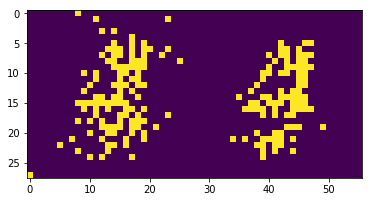

Starting batch: 57
Trained batch: 57


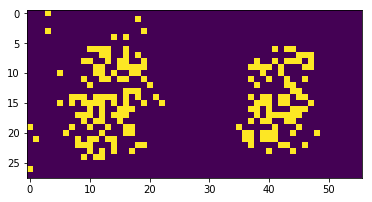

Starting batch: 58
Trained batch: 58


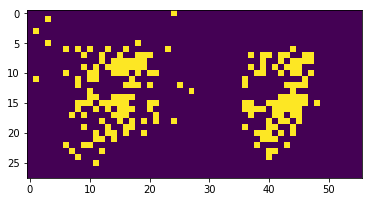

Starting batch: 59
Trained batch: 59


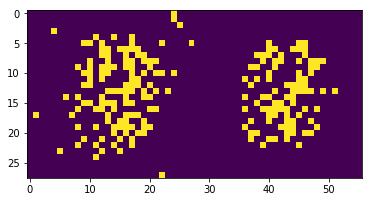

Starting batch: 60
Trained batch: 60


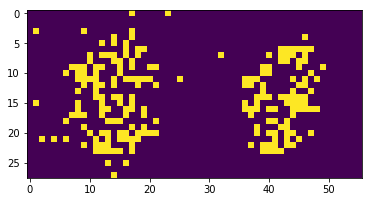

Starting batch: 61
Trained batch: 61


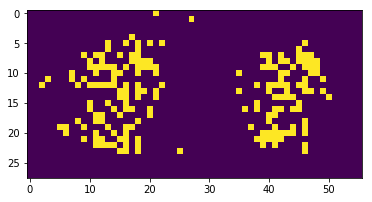

Starting batch: 62
Trained batch: 62


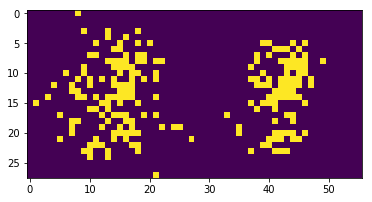

Starting batch: 63
Trained batch: 63


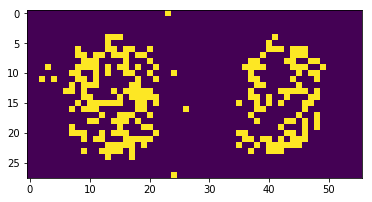

Starting batch: 64
Trained batch: 64


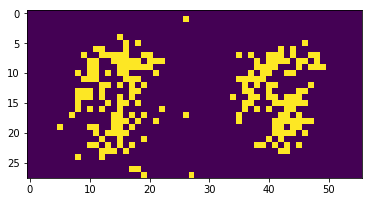

Starting batch: 65
Trained batch: 65


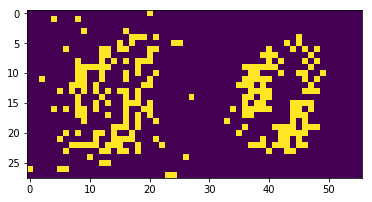

Starting batch: 66
Trained batch: 66


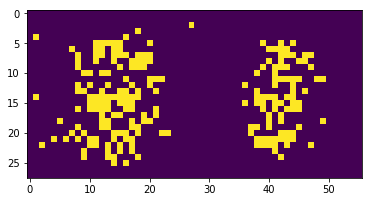

Starting batch: 67
Trained batch: 67


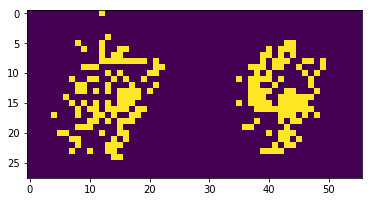

Starting batch: 68
Trained batch: 68


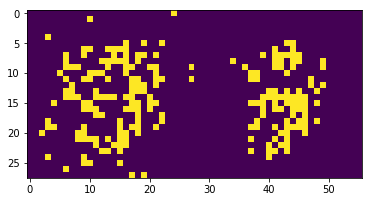

Starting batch: 69
Trained batch: 69


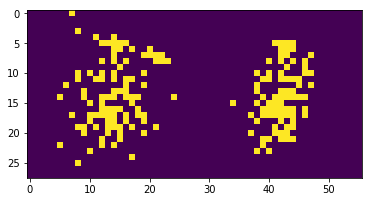

Starting batch: 70
Trained batch: 70


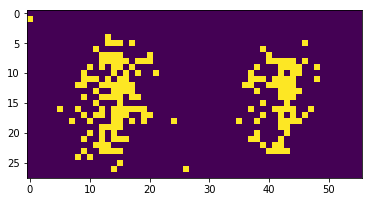

Starting batch: 71
Trained batch: 71


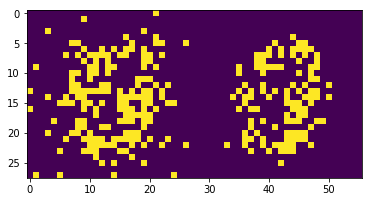

Starting batch: 72
Trained batch: 72


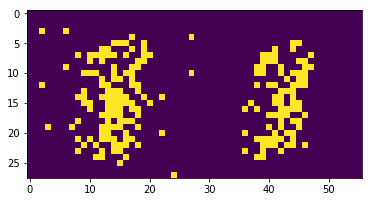

Starting batch: 73
Trained batch: 73


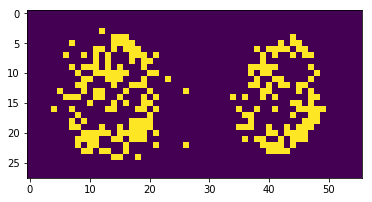

Starting batch: 74
Trained batch: 74


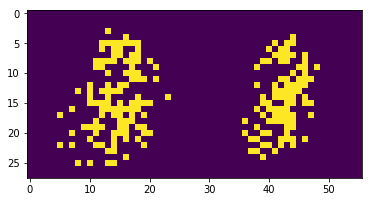

Starting batch: 75
Trained batch: 75


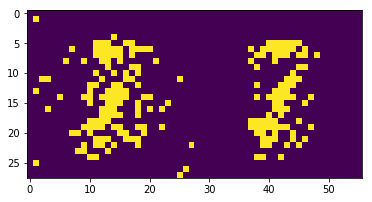

Starting batch: 76
Trained batch: 76


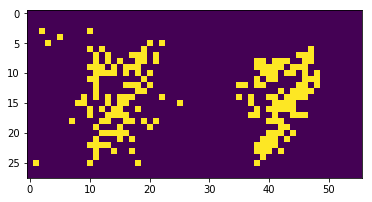

Starting batch: 77
Trained batch: 77


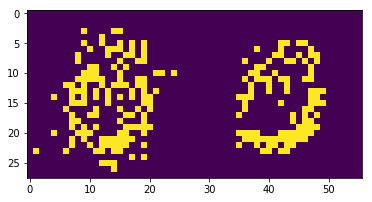

Starting batch: 78
Trained batch: 78


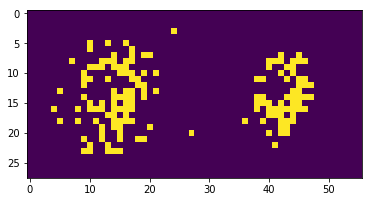

Starting batch: 79
Trained batch: 79


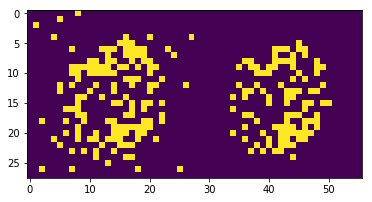

Starting batch: 80
Trained batch: 80


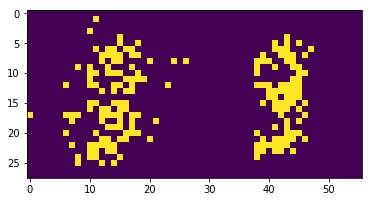

Starting batch: 81
Trained batch: 81


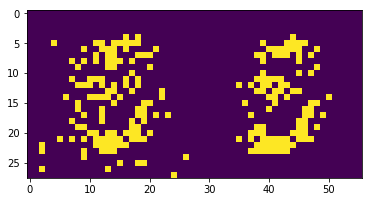

Starting batch: 82
Trained batch: 82


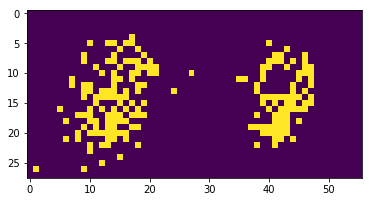

Starting batch: 83
Trained batch: 83


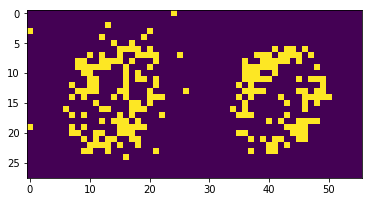

Starting batch: 84
Trained batch: 84


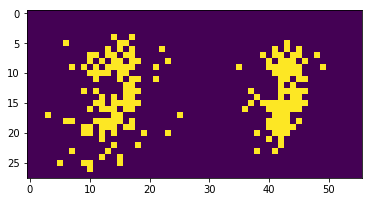

Starting batch: 85
Trained batch: 85


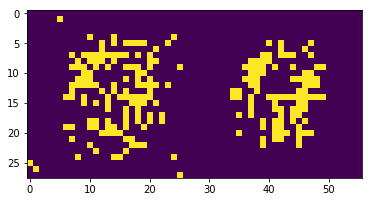

Starting batch: 86
Trained batch: 86


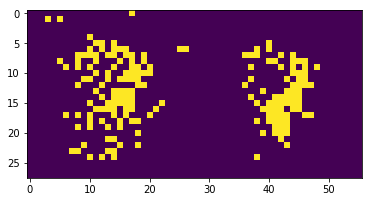

Starting batch: 87
Trained batch: 87


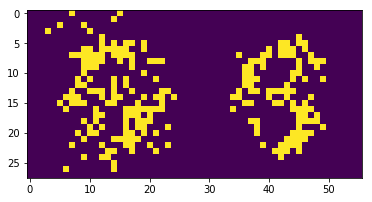

Starting batch: 88
Trained batch: 88


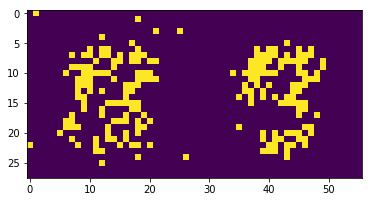

Starting batch: 89
Trained batch: 89


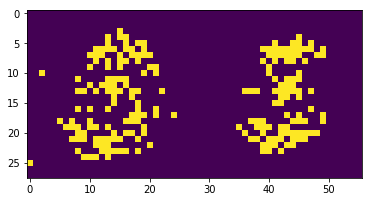

Starting batch: 90
Trained batch: 90


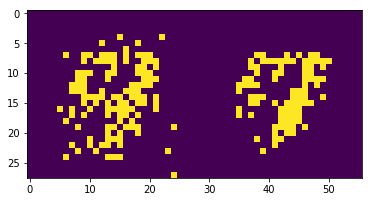

Starting batch: 91
Trained batch: 91


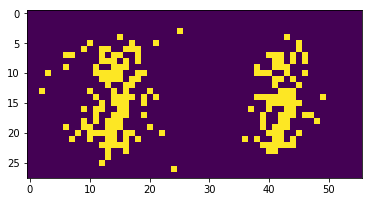

Starting batch: 92
Trained batch: 92


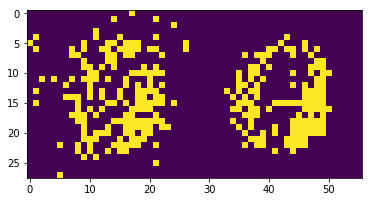

Starting batch: 93
Trained batch: 93


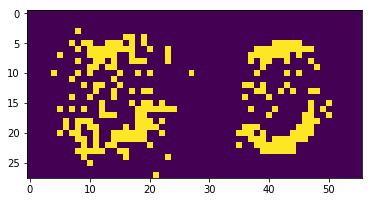

Starting batch: 94
Trained batch: 94


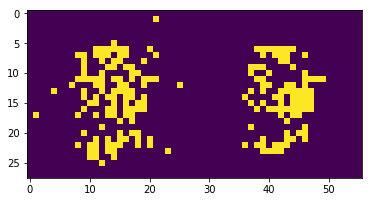

Starting batch: 95
Trained batch: 95


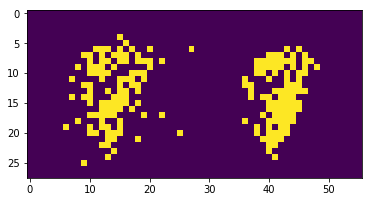

Starting batch: 96
Trained batch: 96


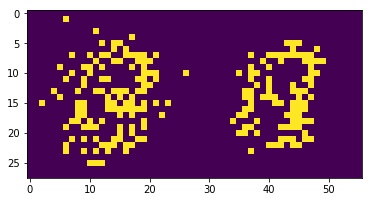

Starting batch: 97
Trained batch: 97


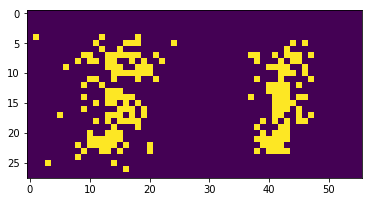

Starting batch: 98
Trained batch: 98


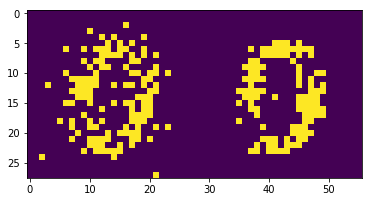

Starting batch: 99
Trained batch: 99


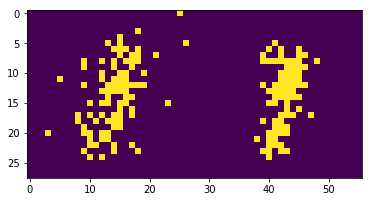

Starting batch: 100
Trained batch: 100


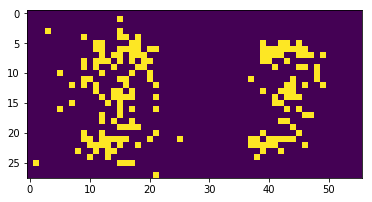

Starting batch: 101
Trained batch: 101


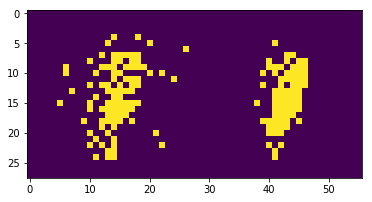

Starting batch: 102
Trained batch: 102


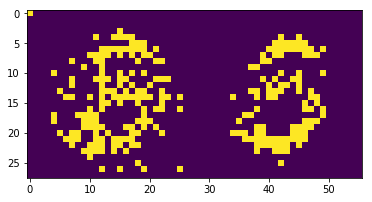

Starting batch: 103
Trained batch: 103


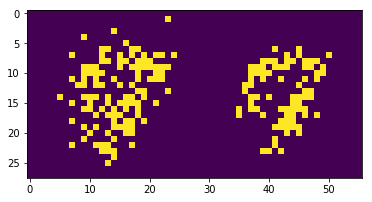

Starting batch: 104
Trained batch: 104


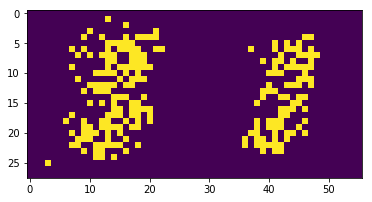

Starting batch: 105
Trained batch: 105


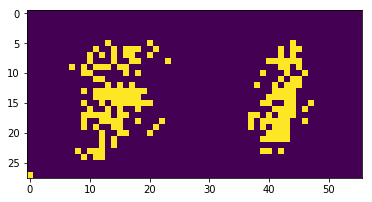

Starting batch: 106
Trained batch: 106


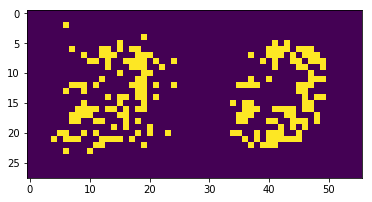

Starting batch: 107
Trained batch: 107


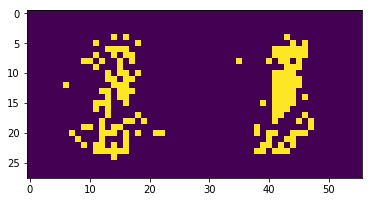

Starting batch: 108
Trained batch: 108


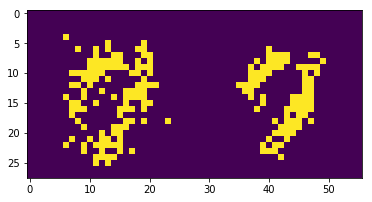

Starting batch: 109
Trained batch: 109


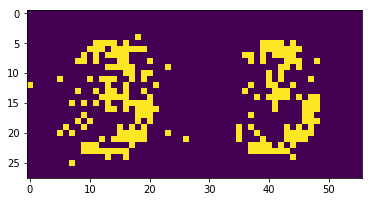

Starting batch: 110
Trained batch: 110


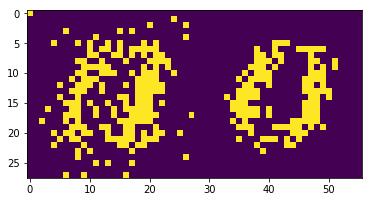

Starting batch: 111
Trained batch: 111


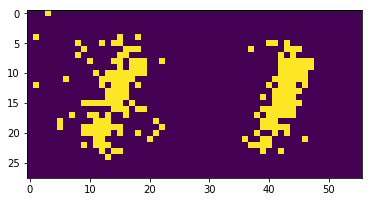

Starting batch: 112
Trained batch: 112


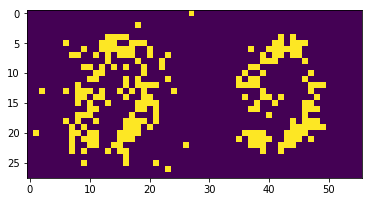

Starting batch: 113
Trained batch: 113


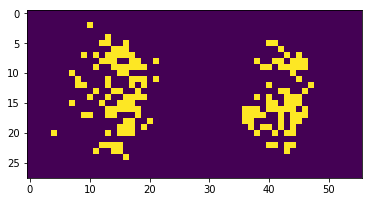

Starting batch: 114
Trained batch: 114


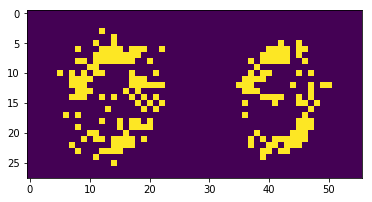

Starting batch: 115
Trained batch: 115


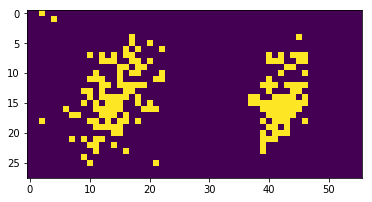

Starting batch: 116
Trained batch: 116


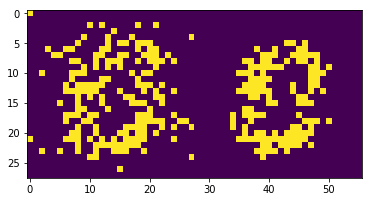

Starting batch: 117
Trained batch: 117


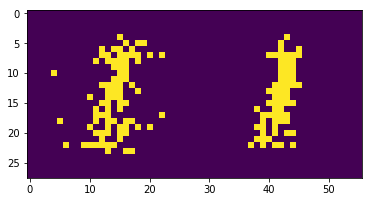

Starting batch: 118
Trained batch: 118


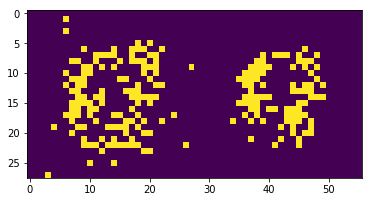

Starting batch: 119
Trained batch: 119


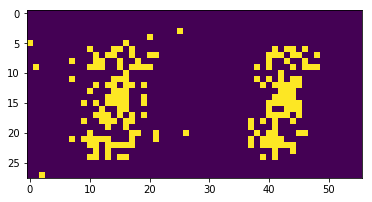

Starting batch: 120
Trained batch: 120


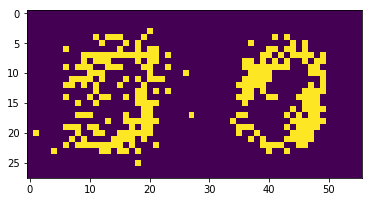

Starting batch: 121
Trained batch: 121


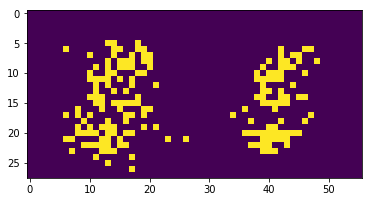

Starting batch: 122
Trained batch: 122


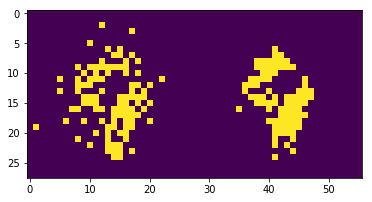

Starting batch: 123
Trained batch: 123


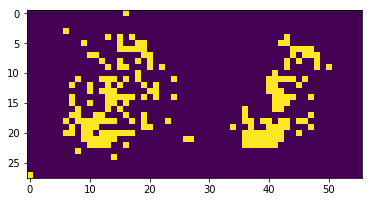

Starting batch: 124
Trained batch: 124


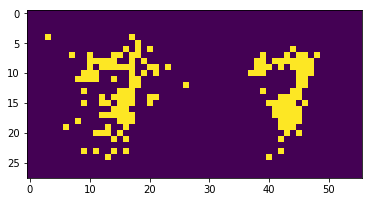

Starting batch: 125
Trained batch: 125


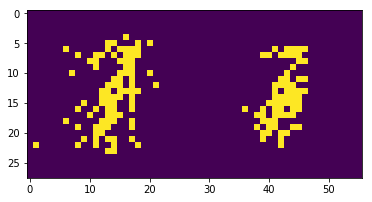

Starting batch: 126
Trained batch: 126


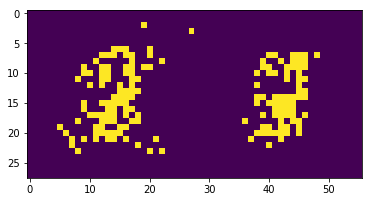

Starting batch: 127
Trained batch: 127


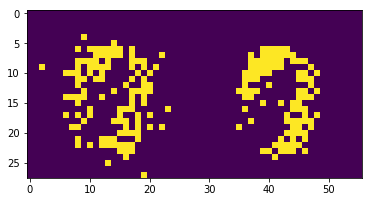

Starting batch: 128
Trained batch: 128


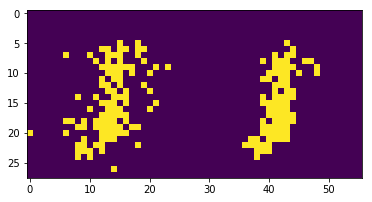

Starting batch: 129
Trained batch: 129


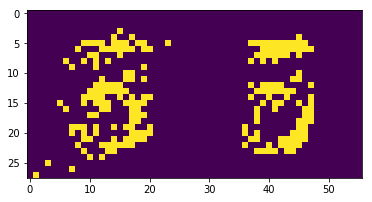

Starting batch: 130
Trained batch: 130


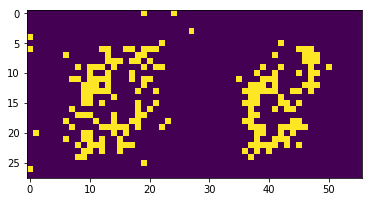

Starting batch: 131
Trained batch: 131


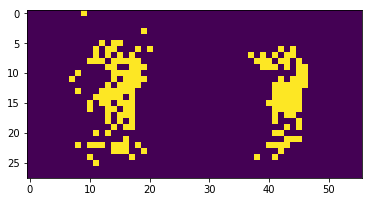

Starting batch: 132
Trained batch: 132


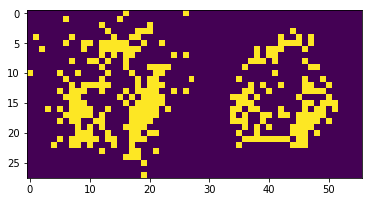

Starting batch: 133
Trained batch: 133


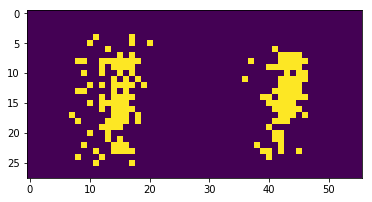

Starting batch: 134
Trained batch: 134


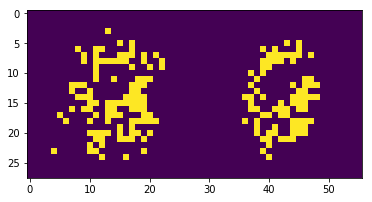

Starting batch: 135
Trained batch: 135


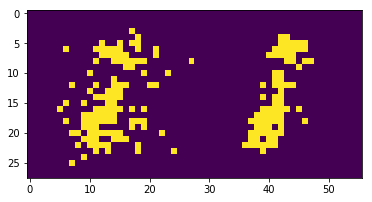

Starting batch: 136
Trained batch: 136


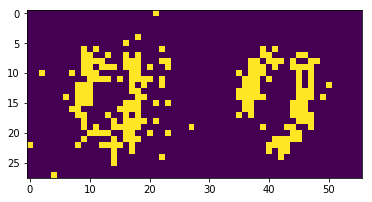

Starting batch: 137
Trained batch: 137


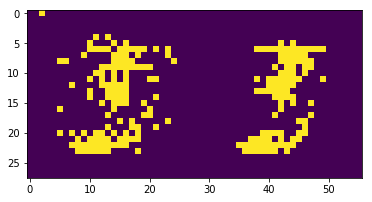

Starting batch: 138
Trained batch: 138


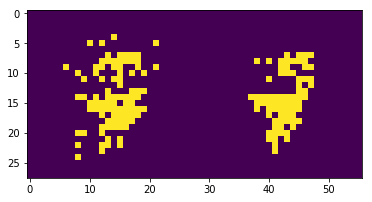

Starting batch: 139
Trained batch: 139


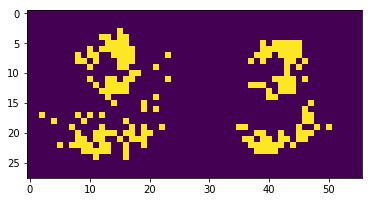

Starting batch: 140
Trained batch: 140


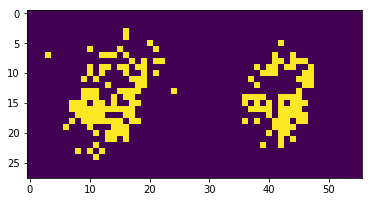

Starting batch: 141
Trained batch: 141


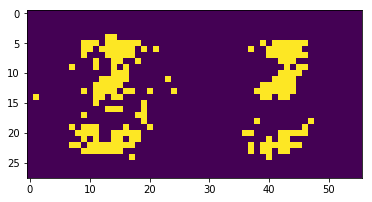

Starting batch: 142
Trained batch: 142


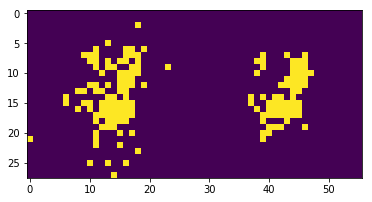

Starting batch: 143
Trained batch: 143


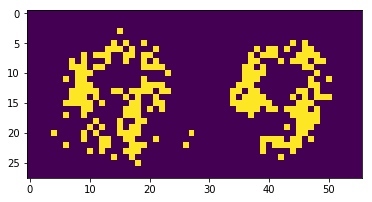

Starting batch: 144
Trained batch: 144


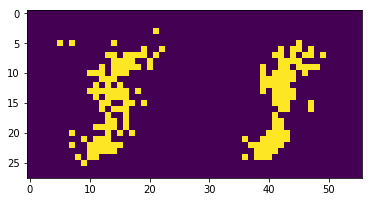

Starting batch: 145
Trained batch: 145


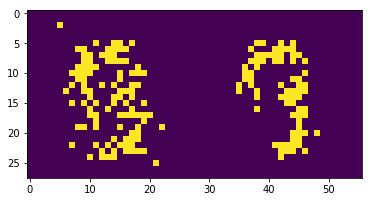

Starting batch: 146
Trained batch: 146


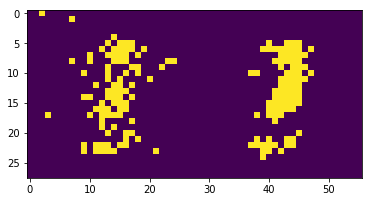

Starting batch: 147
Trained batch: 147


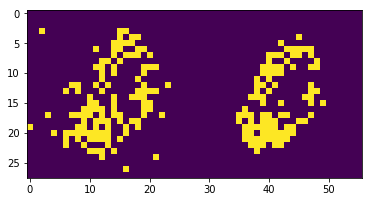

Starting batch: 148
Trained batch: 148


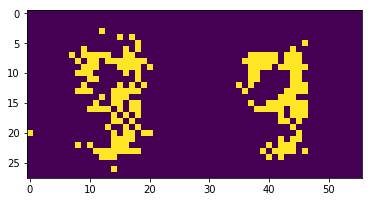

Starting batch: 149
Trained batch: 149


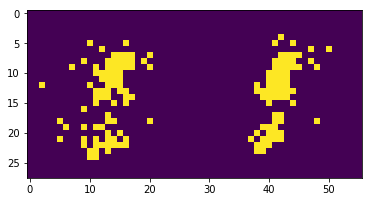

Starting batch: 150
Trained batch: 150


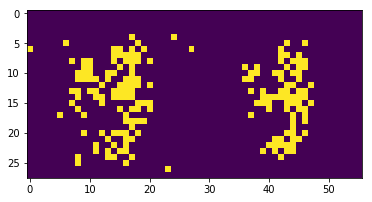

Starting batch: 151
Trained batch: 151


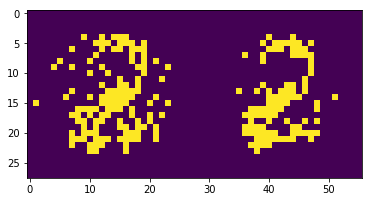

Starting batch: 152
Trained batch: 152


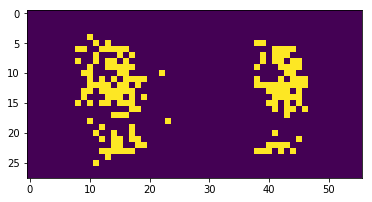

Starting batch: 153
Trained batch: 153


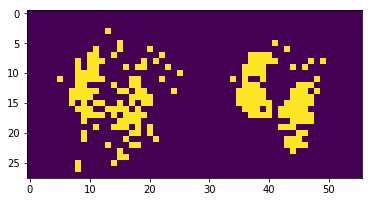

Starting batch: 154
Trained batch: 154


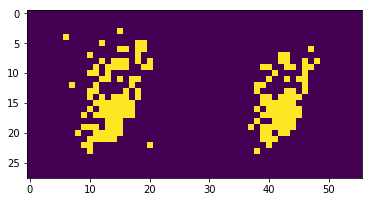

Starting batch: 155
Trained batch: 155


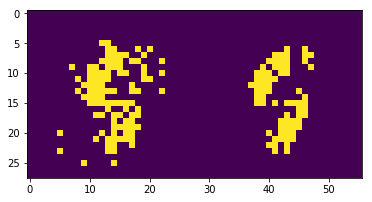

Starting batch: 156
Trained batch: 156


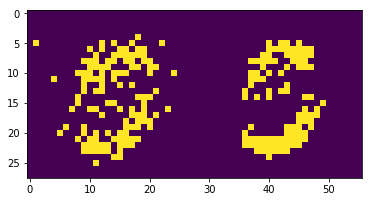

Starting batch: 157
Trained batch: 157


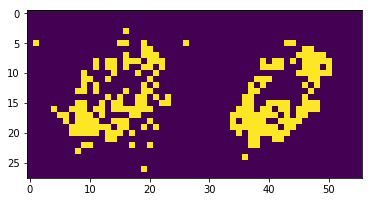

Starting batch: 158
Trained batch: 158


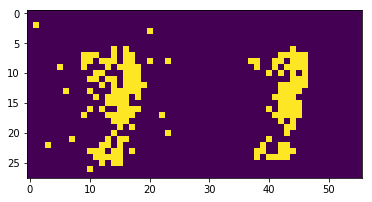

Starting batch: 159
Trained batch: 159


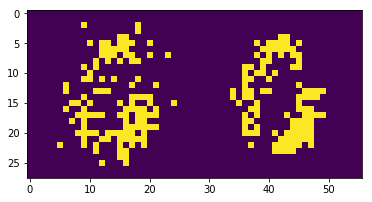

Starting batch: 160
Trained batch: 160


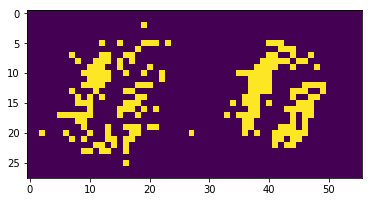

Starting batch: 161
Trained batch: 161


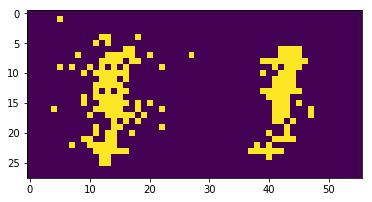

Starting batch: 162
Trained batch: 162


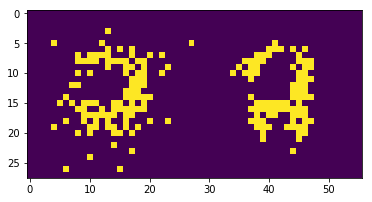

Starting batch: 163
Trained batch: 163


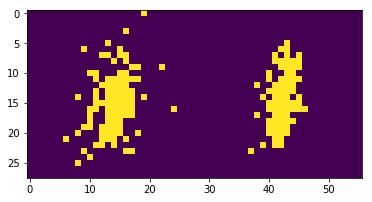

Starting batch: 164
Trained batch: 164


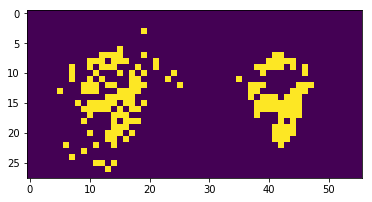

Starting batch: 165
Trained batch: 165


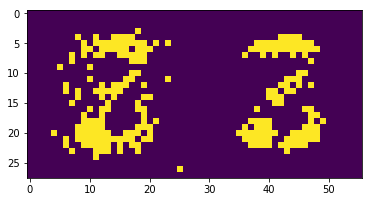

Starting batch: 166
Trained batch: 166


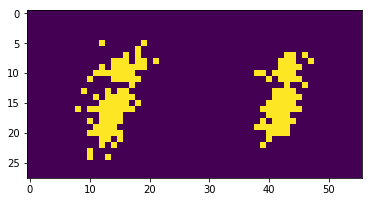

Starting batch: 167
Trained batch: 167


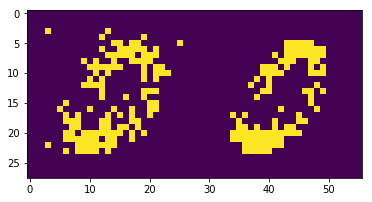

Starting batch: 168
Trained batch: 168


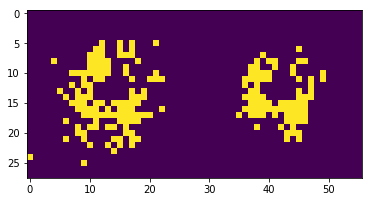

Starting batch: 169
Trained batch: 169


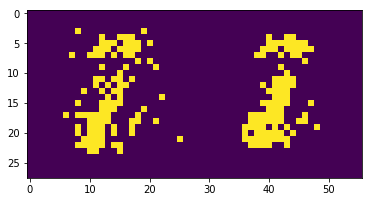

Starting batch: 170
Trained batch: 170


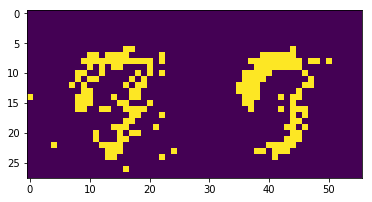

Starting batch: 171
Trained batch: 171


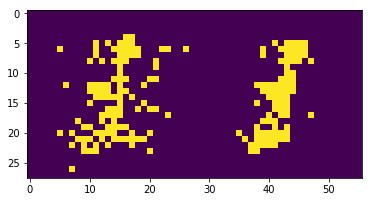

Starting batch: 172
Trained batch: 172


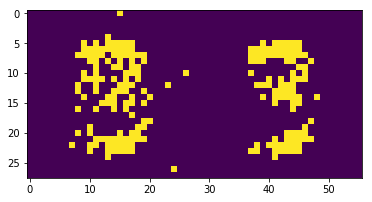

Starting batch: 173
Trained batch: 173


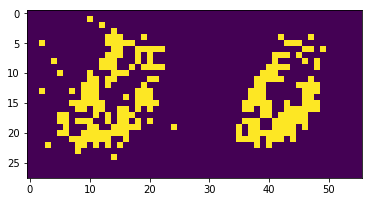

Starting batch: 174
Trained batch: 174


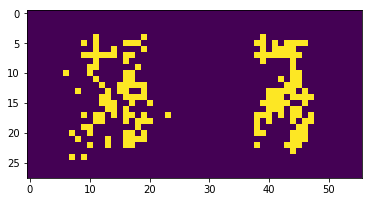

Starting batch: 175
Trained batch: 175


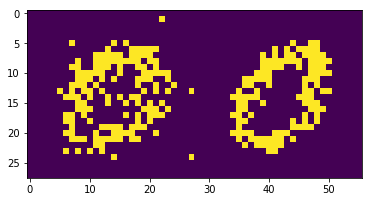

Starting batch: 176
Trained batch: 176


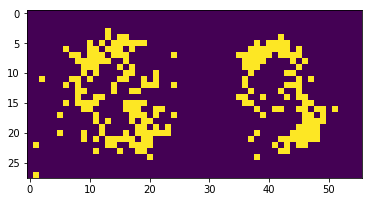

Starting batch: 177
Trained batch: 177


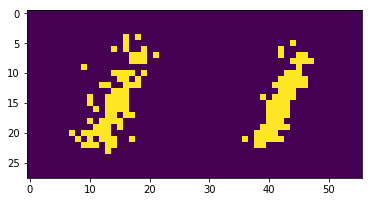

Starting batch: 178
Trained batch: 178


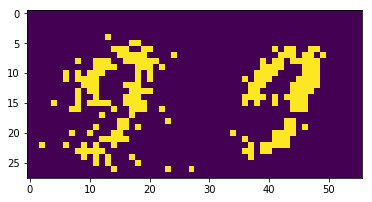

Starting batch: 179
Trained batch: 179


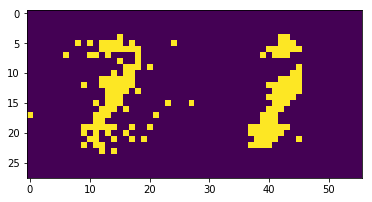

Starting batch: 180
Trained batch: 180


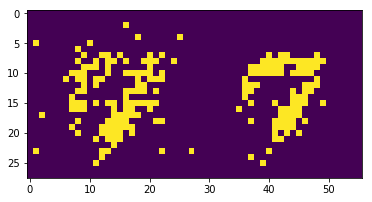

Starting batch: 181
Trained batch: 181


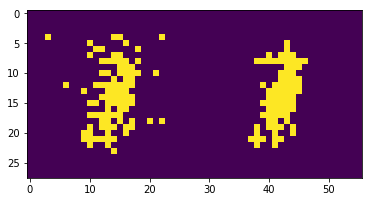

Starting batch: 182
Trained batch: 182


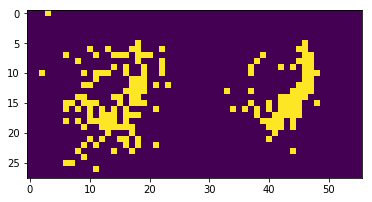

Starting batch: 183
Trained batch: 183


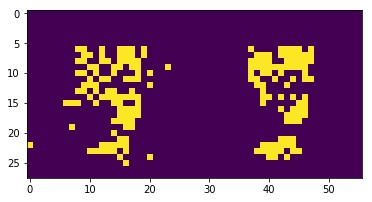

Starting batch: 184
Trained batch: 184


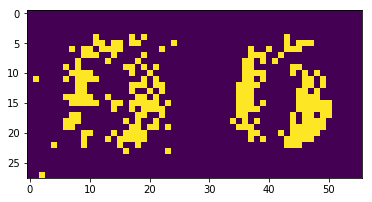

Starting batch: 185
Trained batch: 185


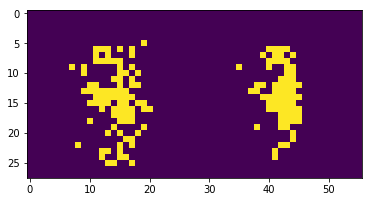

Starting batch: 186
Trained batch: 186


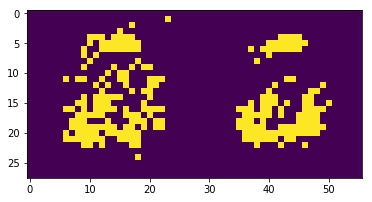

Starting batch: 187
Trained batch: 187


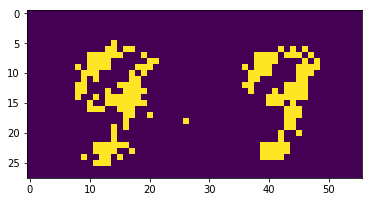

Starting batch: 188
Trained batch: 188


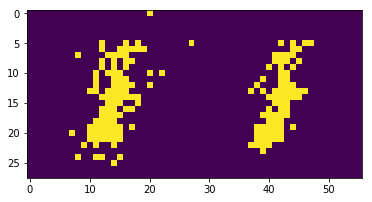

Starting batch: 189
Trained batch: 189


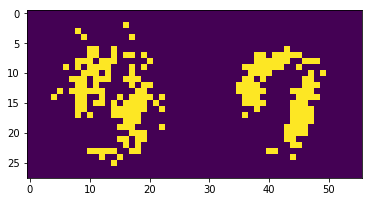

Starting batch: 190
Trained batch: 190


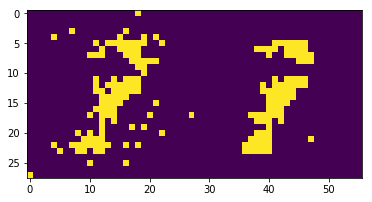

Starting batch: 191
Trained batch: 191


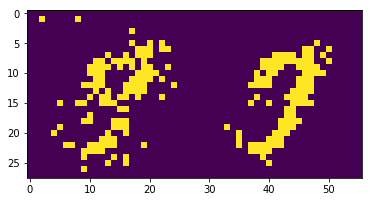

Starting batch: 192
Trained batch: 192


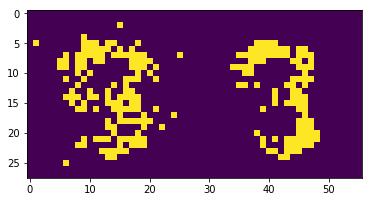

Starting batch: 193
Trained batch: 193


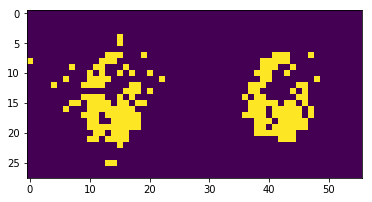

Starting batch: 194
Trained batch: 194


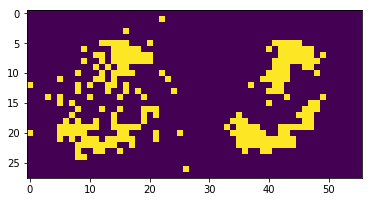

Starting batch: 195
Trained batch: 195


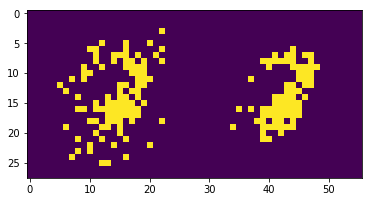

Starting batch: 196
Trained batch: 196


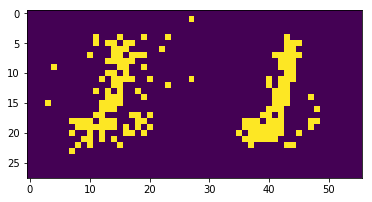

Starting batch: 197
Trained batch: 197


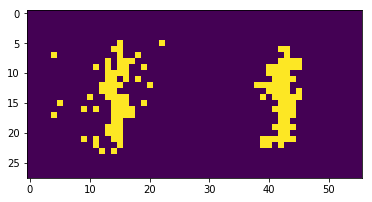

Starting batch: 198
Trained batch: 198


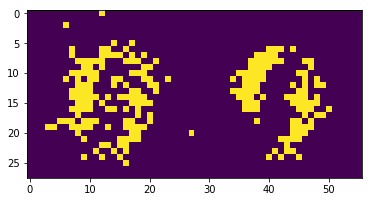

Starting batch: 199
Trained batch: 199


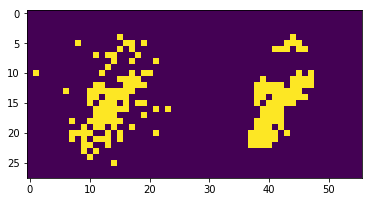

Starting batch: 200
Trained batch: 200


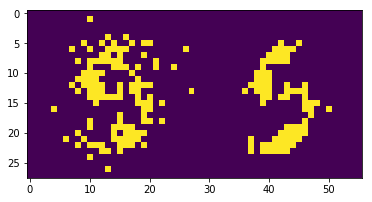

Starting batch: 201
Trained batch: 201


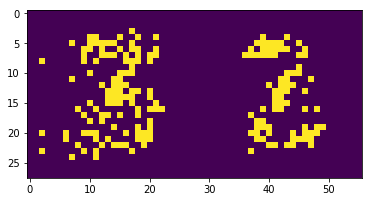

Starting batch: 202
Trained batch: 202


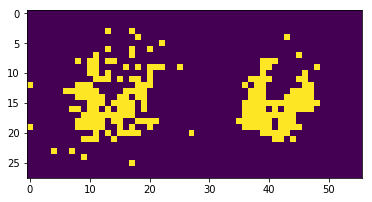

Starting batch: 203
Trained batch: 203


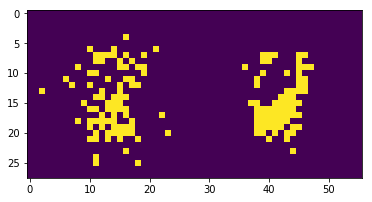

Starting batch: 204
Trained batch: 204


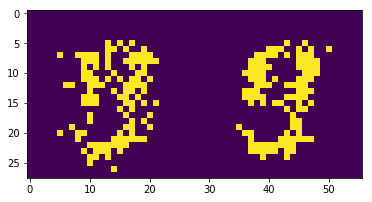

Starting batch: 205
Trained batch: 205


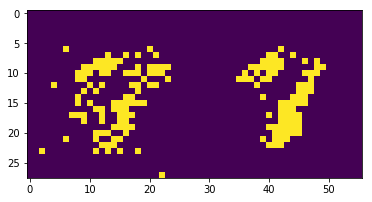

Starting batch: 206
Trained batch: 206


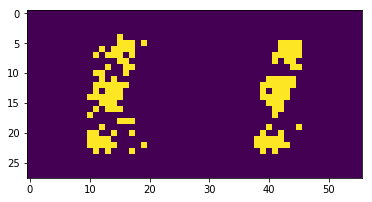

Starting batch: 207
Trained batch: 207


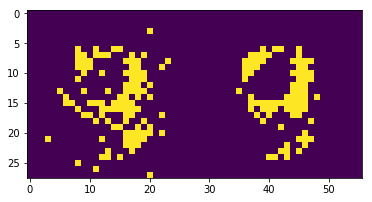

Starting batch: 208
Trained batch: 208


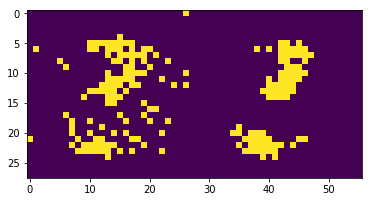

Starting batch: 209
Trained batch: 209


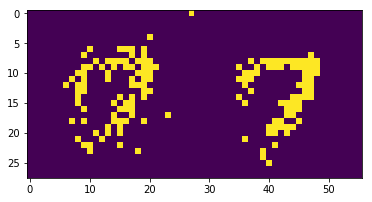

Starting batch: 210
Trained batch: 210


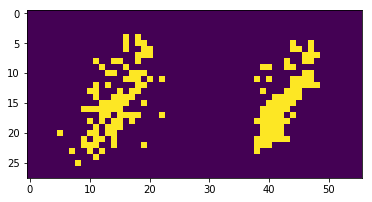

Starting batch: 211
Trained batch: 211


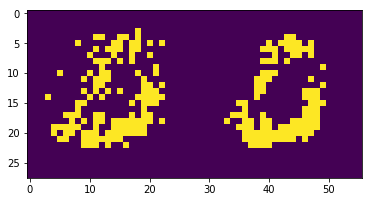

Starting batch: 212
Trained batch: 212


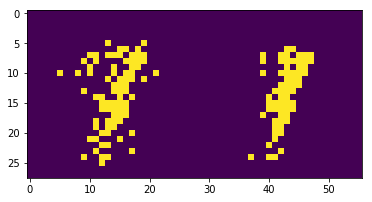

Starting batch: 213
Trained batch: 213


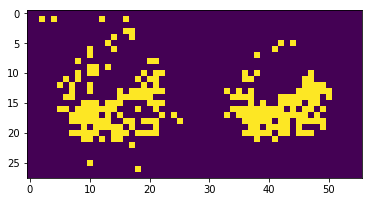

Starting batch: 214
Trained batch: 214


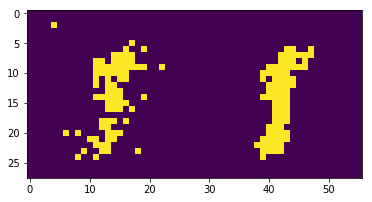

Starting batch: 215
Trained batch: 215


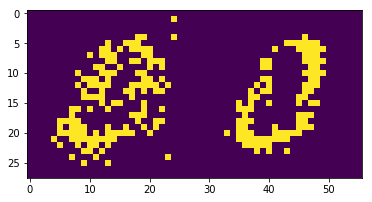

Starting batch: 216
Trained batch: 216


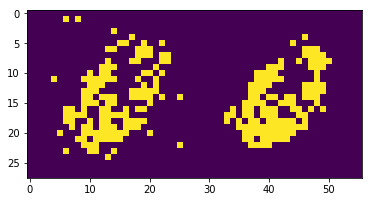

Starting batch: 217
Trained batch: 217


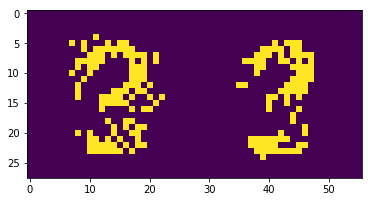

Starting batch: 218
Trained batch: 218


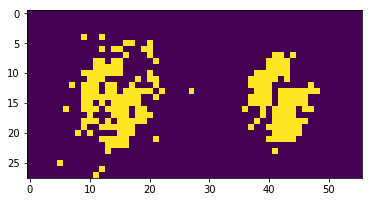

Starting batch: 219
Trained batch: 219


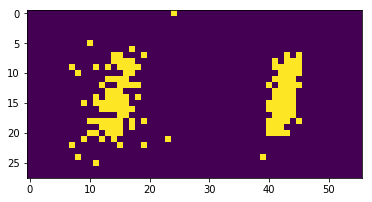

Starting batch: 220
Trained batch: 220


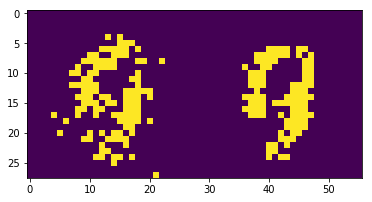

Starting batch: 221
Trained batch: 221


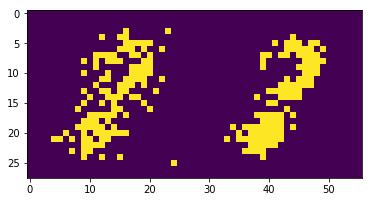

Starting batch: 222
Trained batch: 222


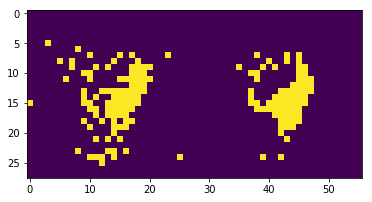

Starting batch: 223
Trained batch: 223


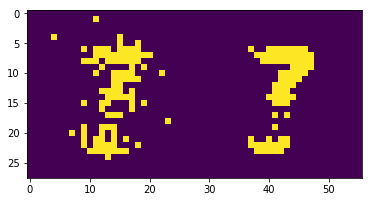

Starting batch: 224
Trained batch: 224


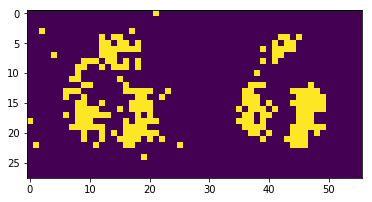

Starting batch: 225
Trained batch: 225


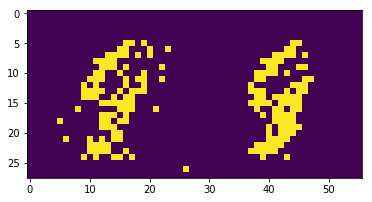

Starting batch: 226
Trained batch: 226


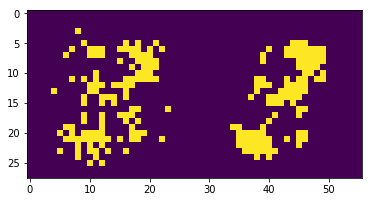

Starting batch: 227
Trained batch: 227


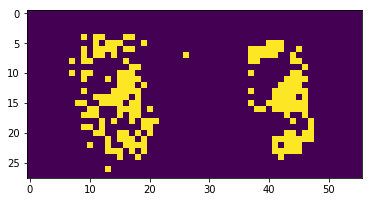

Starting batch: 228
Trained batch: 228


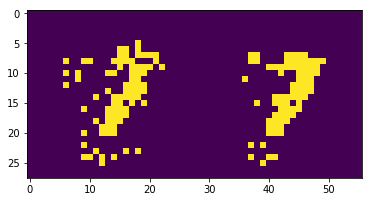

Starting batch: 229
Trained batch: 229


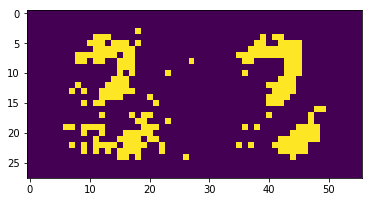

Starting batch: 230
Trained batch: 230


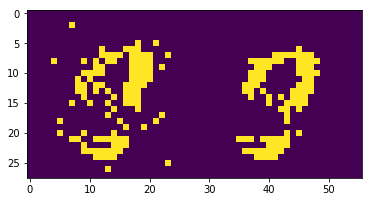

Starting batch: 231
Trained batch: 231


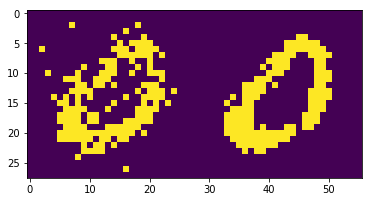

Starting batch: 232
Trained batch: 232


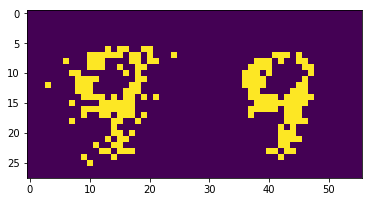

Starting batch: 233
Trained batch: 233


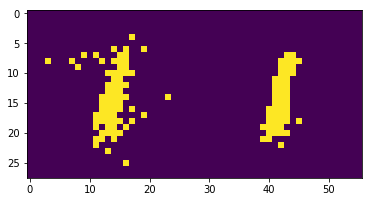

Starting batch: 234
Trained batch: 234


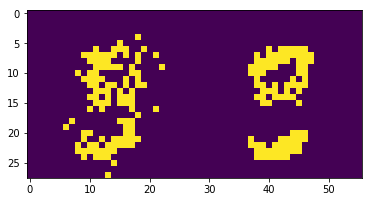

Starting batch: 235
Trained batch: 235


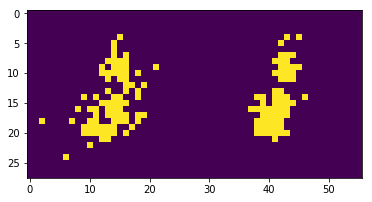

Starting batch: 236
Trained batch: 236


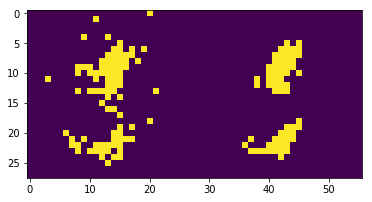

Starting batch: 237
Trained batch: 237


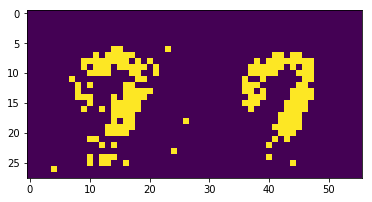

Starting batch: 238
Trained batch: 238


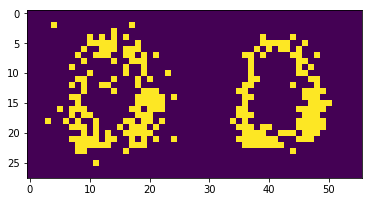

Starting batch: 239
Trained batch: 239


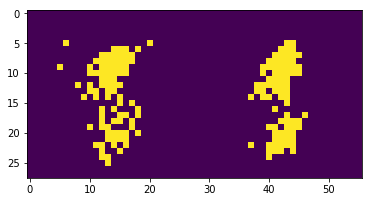

Starting batch: 240
Trained batch: 240


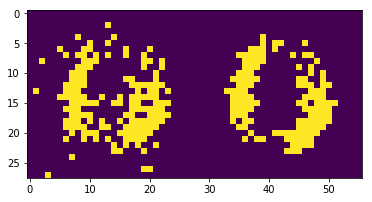

Starting batch: 241
Trained batch: 241


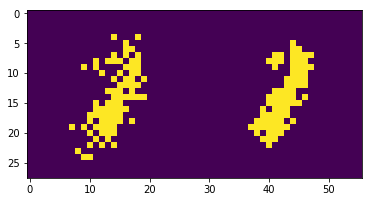

Starting batch: 242
Trained batch: 242


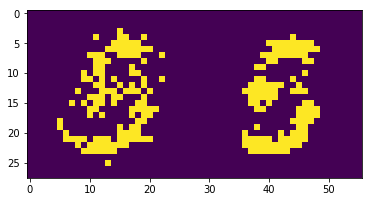

Starting batch: 243
Trained batch: 243


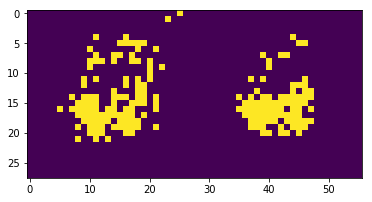

Starting batch: 244
Trained batch: 244


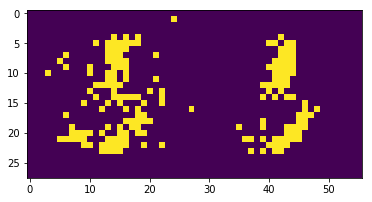

Starting batch: 245
Trained batch: 245


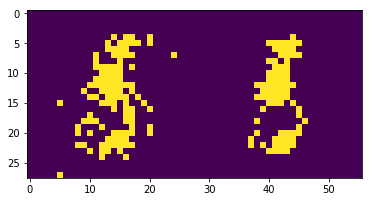

Starting batch: 246
Trained batch: 246


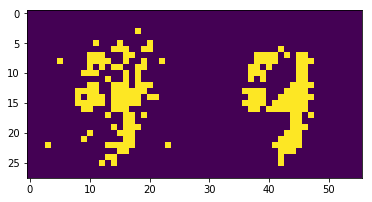

Starting batch: 247
Trained batch: 247


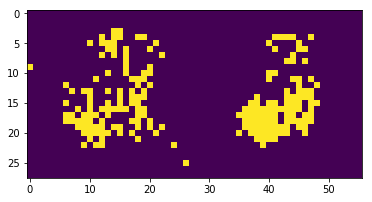

Starting batch: 248
Trained batch: 248


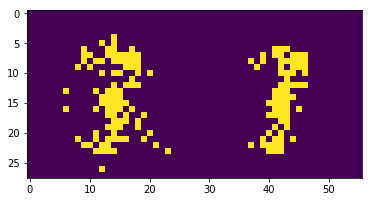

Starting batch: 249
Trained batch: 249


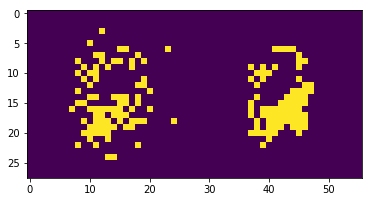

Starting batch: 250
Trained batch: 250


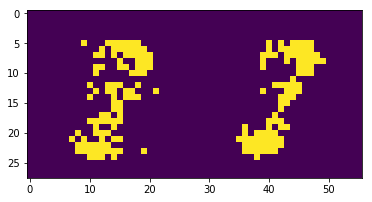

Starting batch: 251
Trained batch: 251


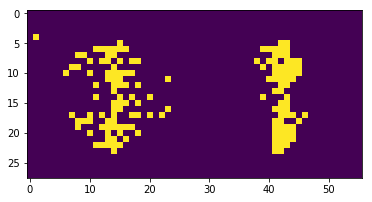

Starting batch: 252
Trained batch: 252


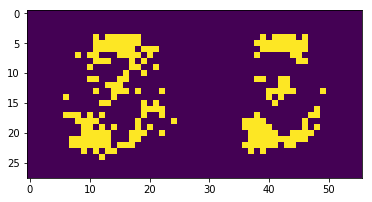

Starting batch: 253
Trained batch: 253


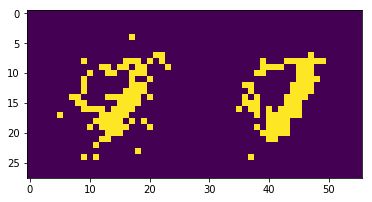

Starting batch: 254
Trained batch: 254


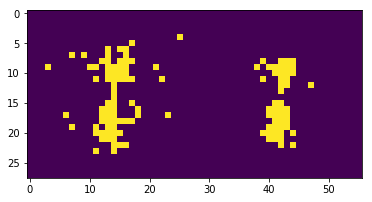

Starting batch: 255
Trained batch: 255


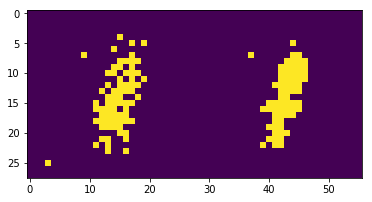

Starting batch: 256
Trained batch: 256


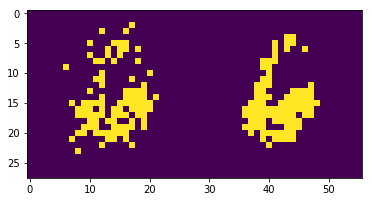

Starting batch: 257
Trained batch: 257


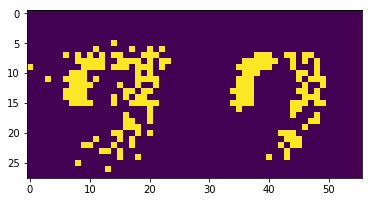

Starting batch: 258
Trained batch: 258


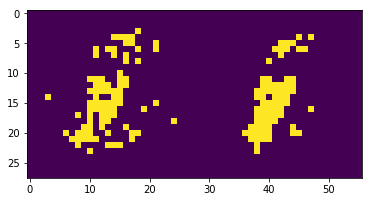

Starting batch: 259
Trained batch: 259


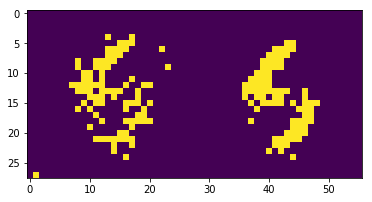

Starting batch: 260
Trained batch: 260


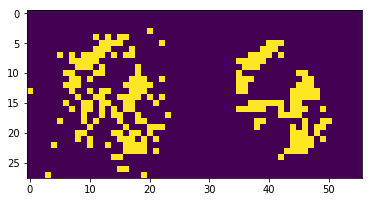

Starting batch: 261
Trained batch: 261


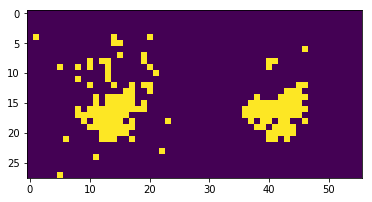

Starting batch: 262
Trained batch: 262


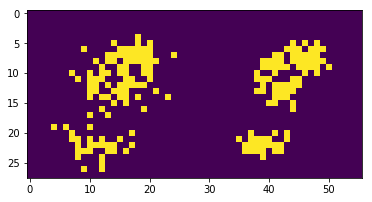

Starting batch: 263
Trained batch: 263


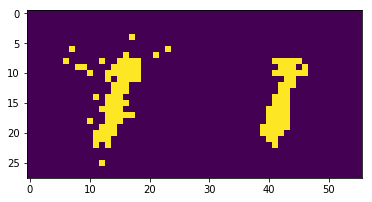

Starting batch: 264
Trained batch: 264


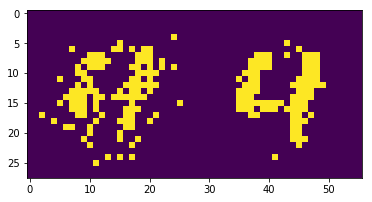

Starting batch: 265
Trained batch: 265


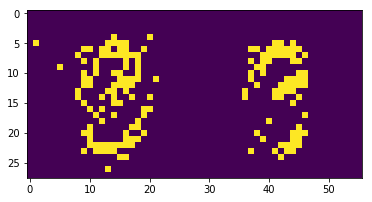

Starting batch: 266
Trained batch: 266


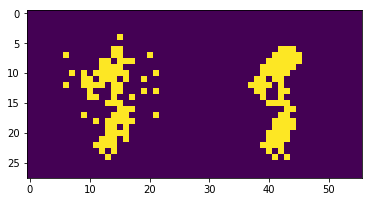

Starting batch: 267
Trained batch: 267


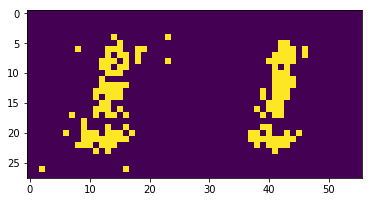

Starting batch: 268
Trained batch: 268


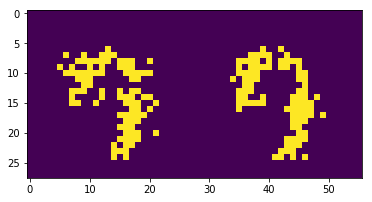

Starting batch: 269
Trained batch: 269


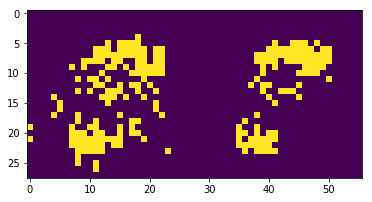

Starting batch: 270
Trained batch: 270


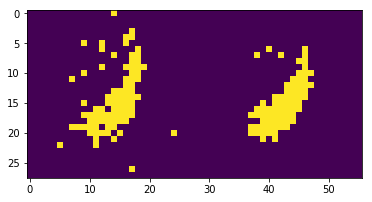

Starting batch: 271
Trained batch: 271


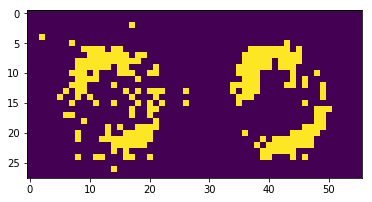

Starting batch: 272
Trained batch: 272


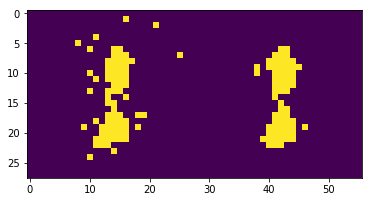

Starting batch: 273
Trained batch: 273


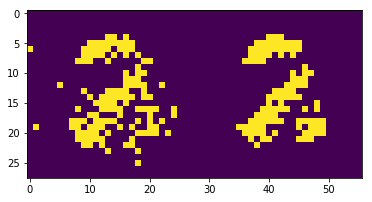

Starting batch: 274
Trained batch: 274


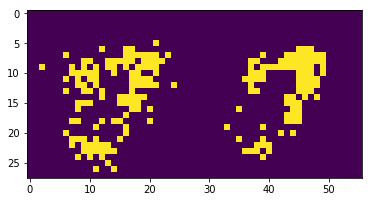

Starting batch: 275
Trained batch: 275


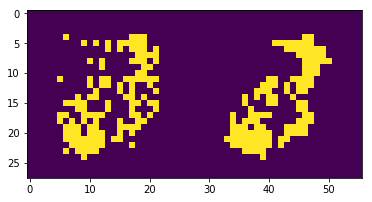

Starting batch: 276
Trained batch: 276


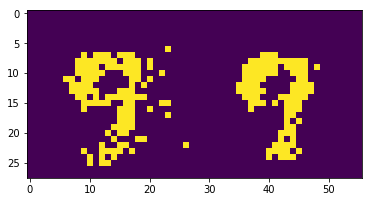

Starting batch: 277
Trained batch: 277


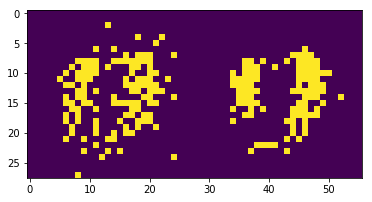

Starting batch: 278
Trained batch: 278


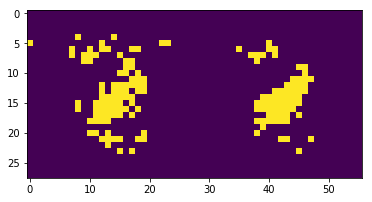

Starting batch: 279
Trained batch: 279


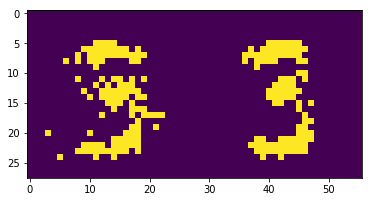

Starting batch: 280
Trained batch: 280


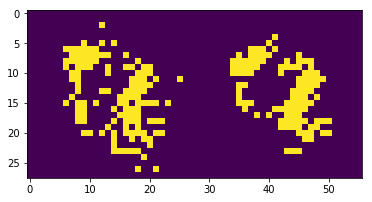

Starting batch: 281
Trained batch: 281


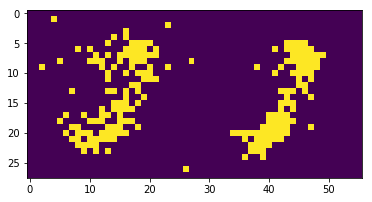

Starting batch: 282
Trained batch: 282


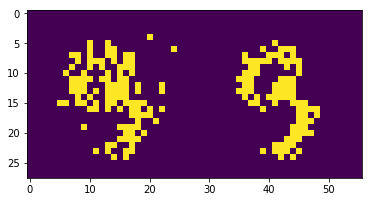

Starting batch: 283
Trained batch: 283


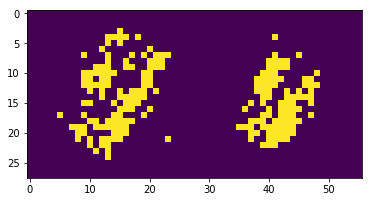

Starting batch: 284
Trained batch: 284


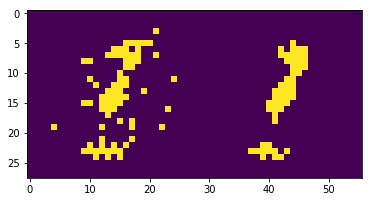

Starting batch: 285
Trained batch: 285


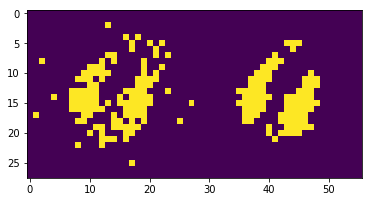

Starting batch: 286
Trained batch: 286


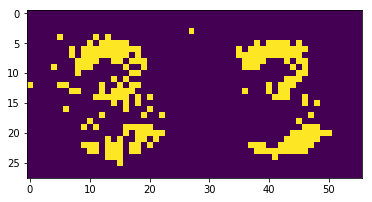

Starting batch: 287
Trained batch: 287


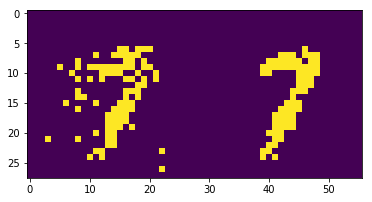

Starting batch: 288
Trained batch: 288


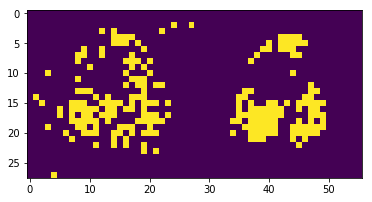

Starting batch: 289
Trained batch: 289


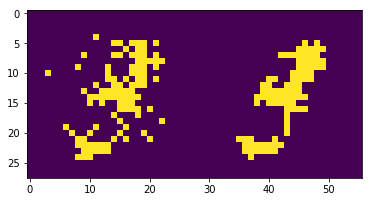

Starting batch: 290
Trained batch: 290


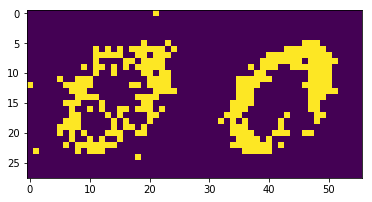

Starting batch: 291
Trained batch: 291


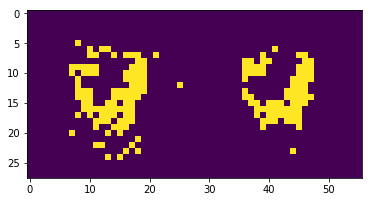

Starting batch: 292
Trained batch: 292


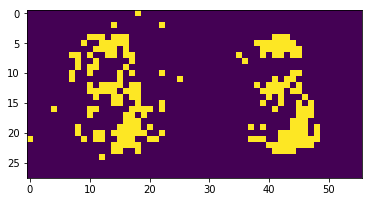

Starting batch: 293
Trained batch: 293


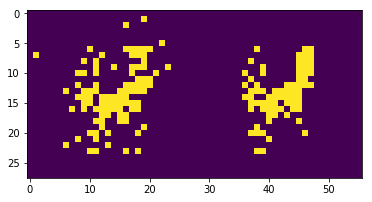

Starting batch: 294
Trained batch: 294


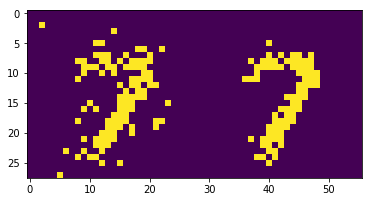

Starting batch: 295
Trained batch: 295


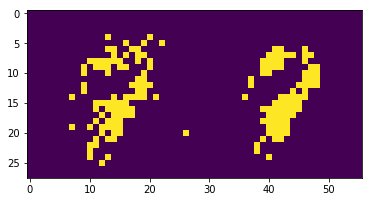

Starting batch: 296
Trained batch: 296


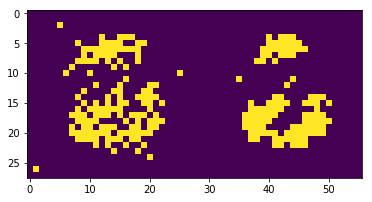

Starting batch: 297
Trained batch: 297


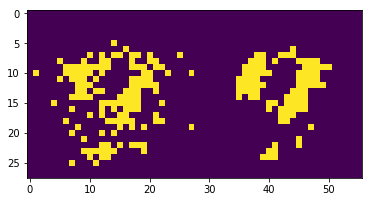

Starting batch: 298
Trained batch: 298


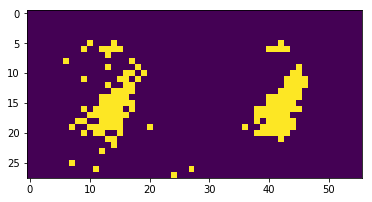

Starting batch: 299
Trained batch: 299


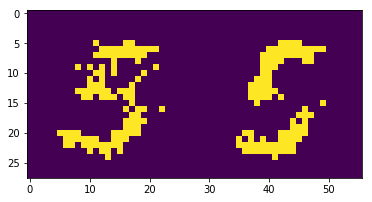

Starting batch: 300
Trained batch: 300


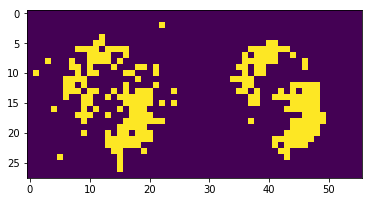

Starting batch: 301
Trained batch: 301


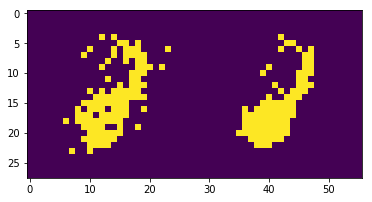

Starting batch: 302
Trained batch: 302


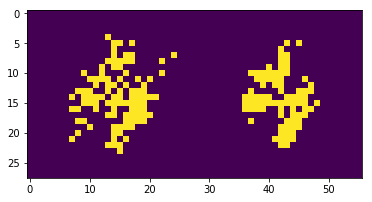

Starting batch: 303
Trained batch: 303


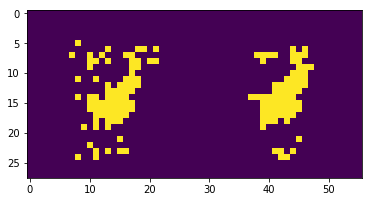

Starting batch: 304
Trained batch: 304


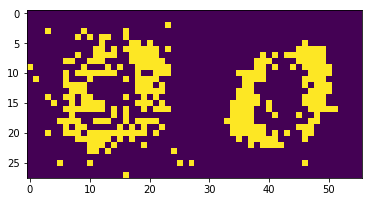

Starting batch: 305
Trained batch: 305


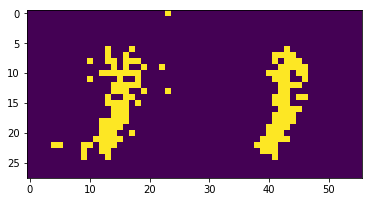

Starting batch: 306
Trained batch: 306


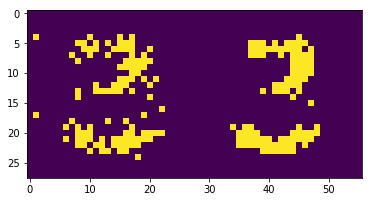

Starting batch: 307
Trained batch: 307


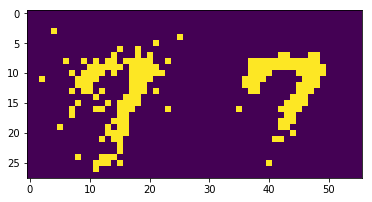

Starting batch: 308
Trained batch: 308


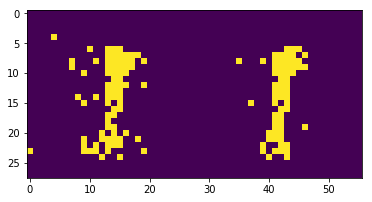

Starting batch: 309
Trained batch: 309


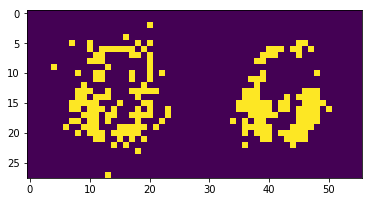

Starting batch: 310
Trained batch: 310


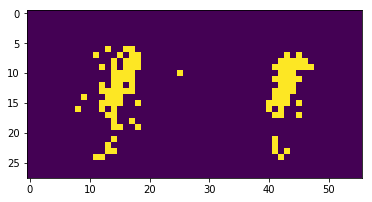

Starting batch: 311
Trained batch: 311


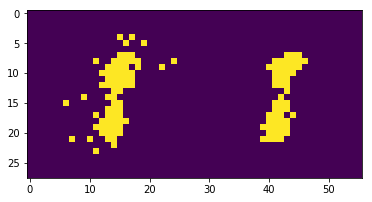

Starting batch: 312
Trained batch: 312


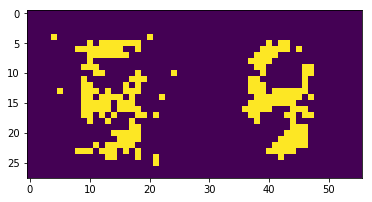

Starting batch: 313
Trained batch: 313


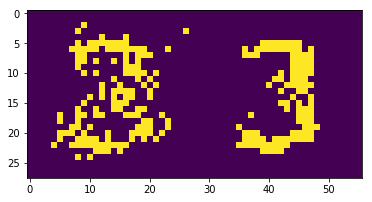

Starting batch: 314
Trained batch: 314


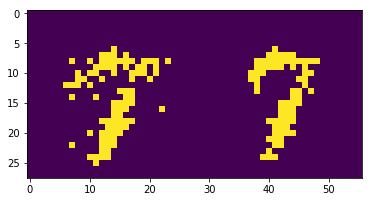

Starting batch: 315
Trained batch: 315


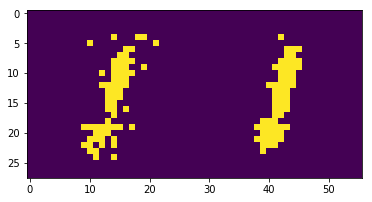

Starting batch: 316
Trained batch: 316


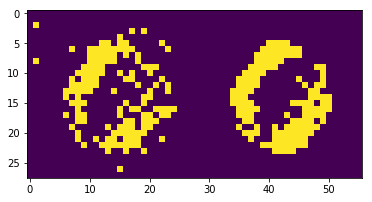

Starting batch: 317
Trained batch: 317


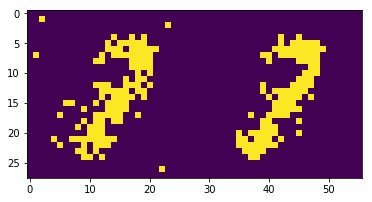

Starting batch: 318
Trained batch: 318


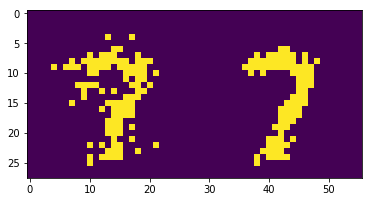

Starting batch: 319
Trained batch: 319


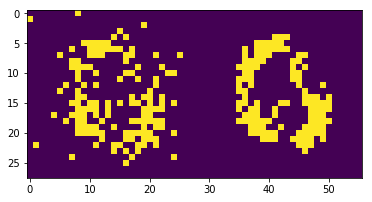

Starting batch: 320
Trained batch: 320


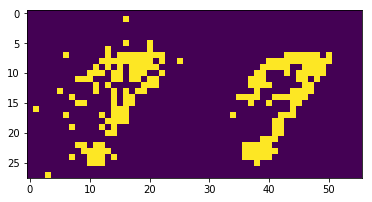

Starting batch: 321
Trained batch: 321


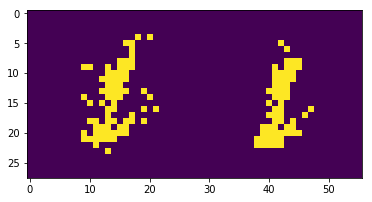

Starting batch: 322
Trained batch: 322


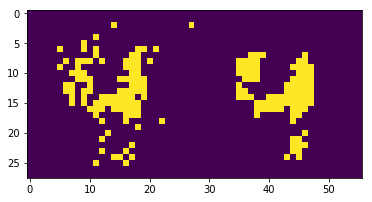

Starting batch: 323
Trained batch: 323


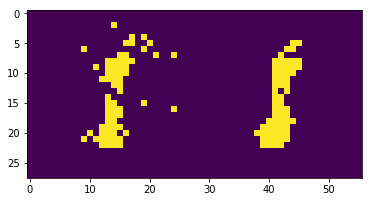

Starting batch: 324
Trained batch: 324


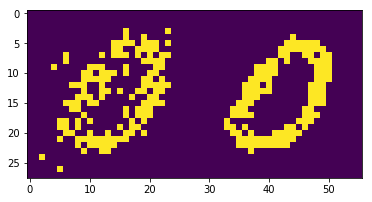

Starting batch: 325
Trained batch: 325


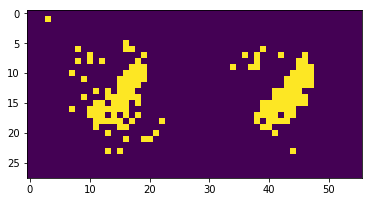

Starting batch: 326
Trained batch: 326


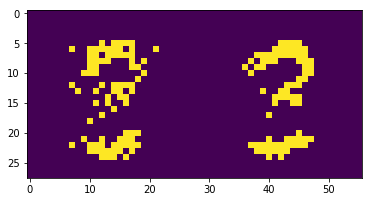

Starting batch: 327
Trained batch: 327


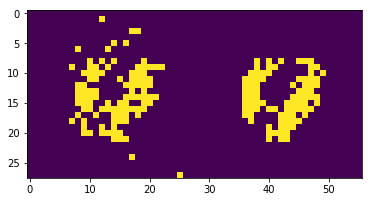

Starting batch: 328
Trained batch: 328


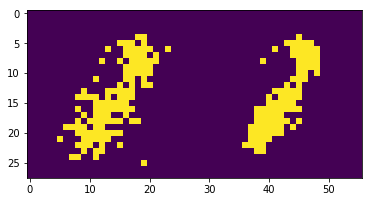

Starting batch: 329
Trained batch: 329


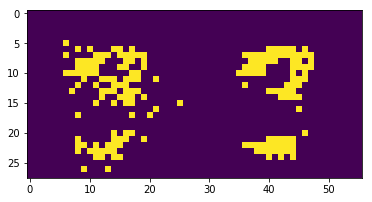

Starting batch: 330
Trained batch: 330


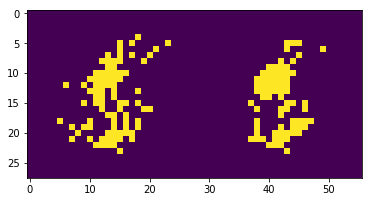

Starting batch: 331
Trained batch: 331


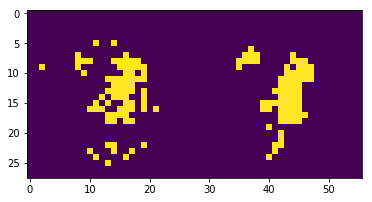

Starting batch: 332
Trained batch: 332


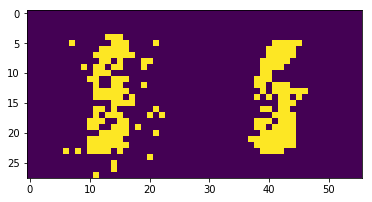

Starting batch: 333
Trained batch: 333


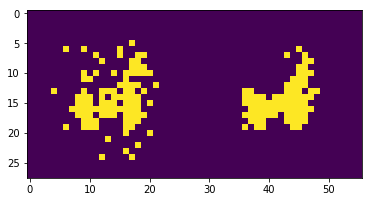

Starting batch: 334
Trained batch: 334


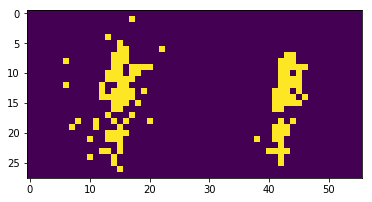

Starting batch: 335
Trained batch: 335


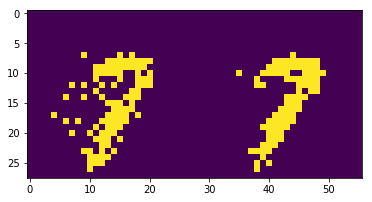

Starting batch: 336
Trained batch: 336


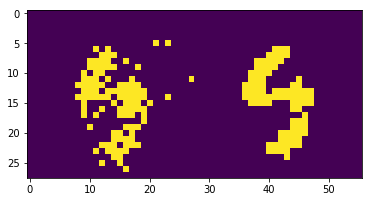

Starting batch: 337
Trained batch: 337


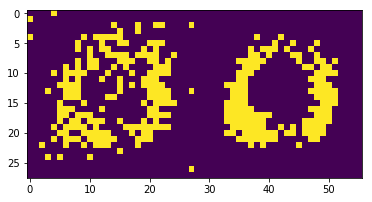

Starting batch: 338
Trained batch: 338


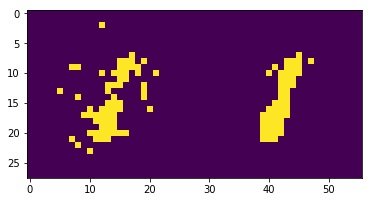

Starting batch: 339
Trained batch: 339


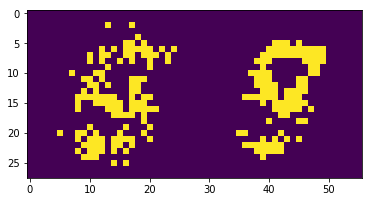

Starting batch: 340
Trained batch: 340


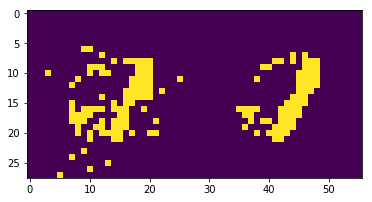

Starting batch: 341
Trained batch: 341


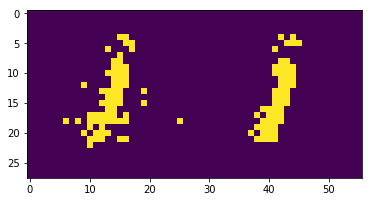

Starting batch: 342
Trained batch: 342


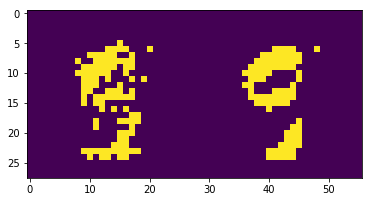

Starting batch: 343
Trained batch: 343


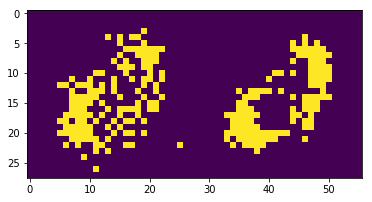

Starting batch: 344
Trained batch: 344


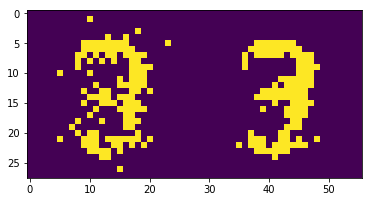

Starting batch: 345
Trained batch: 345


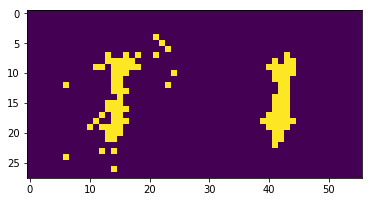

Starting batch: 346
Trained batch: 346


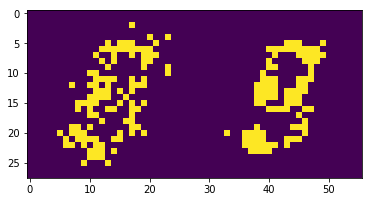

Starting batch: 347
Trained batch: 347


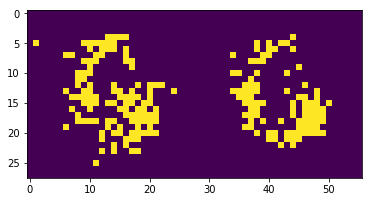

Starting batch: 348
Trained batch: 348


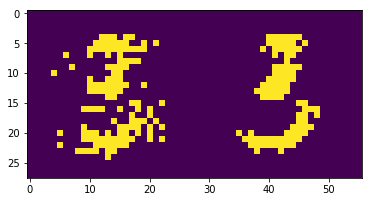

Starting batch: 349
Trained batch: 349


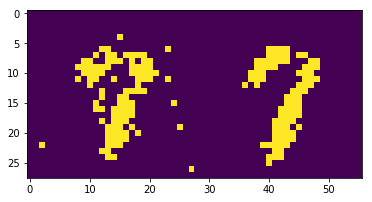

Starting batch: 350
Trained batch: 350


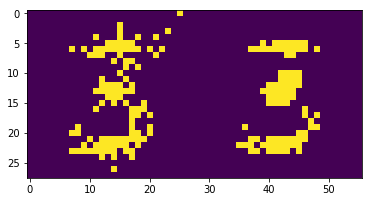

Starting batch: 351
Trained batch: 351


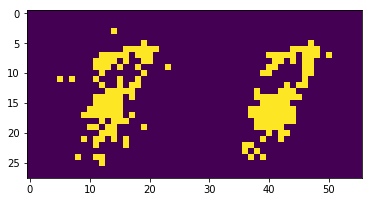

Starting batch: 352
Trained batch: 352


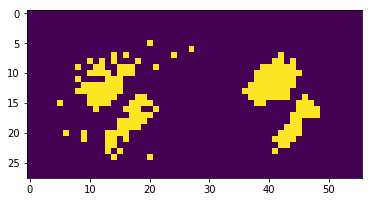

Starting batch: 353
Trained batch: 353


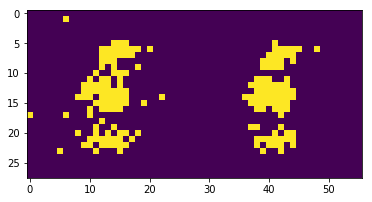

Starting batch: 354
Trained batch: 354


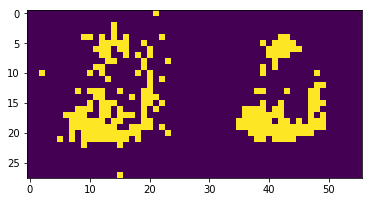

Starting batch: 355
Trained batch: 355


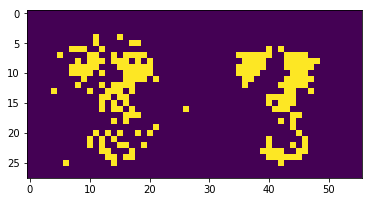

Starting batch: 356
Trained batch: 356


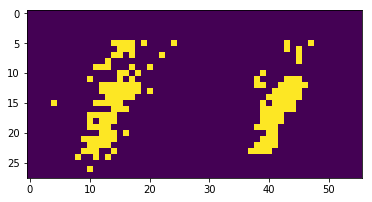

Starting batch: 357
Trained batch: 357


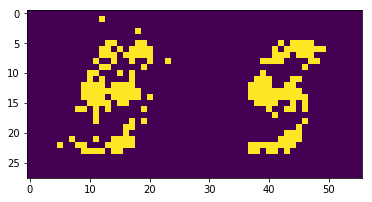

Starting batch: 358
Trained batch: 358


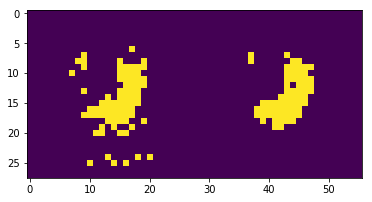

Starting batch: 359
Trained batch: 359


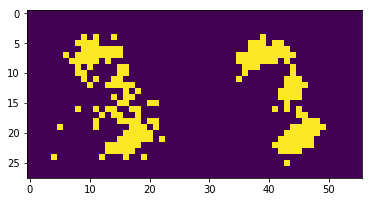

Starting batch: 360
Trained batch: 360


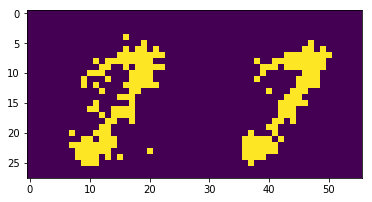

Starting batch: 361
Trained batch: 361


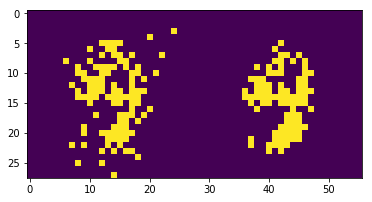

Starting batch: 362
Trained batch: 362


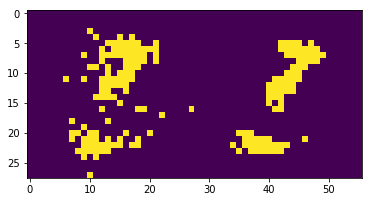

Starting batch: 363
Trained batch: 363


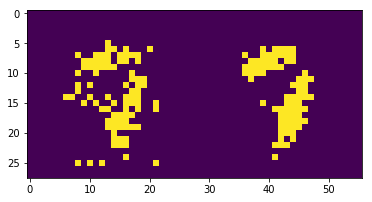

Starting batch: 364
Trained batch: 364


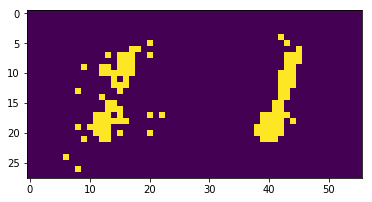

Starting batch: 365
Trained batch: 365


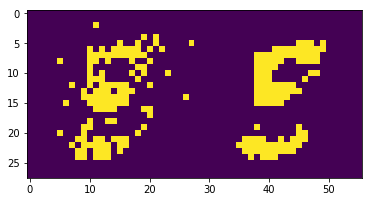

Starting batch: 366
Trained batch: 366


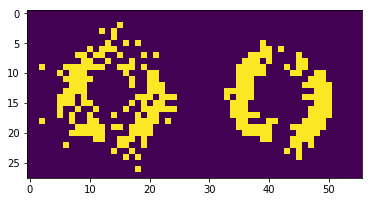

Starting batch: 367
Trained batch: 367


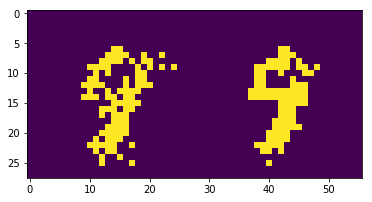

Starting batch: 368
Trained batch: 368


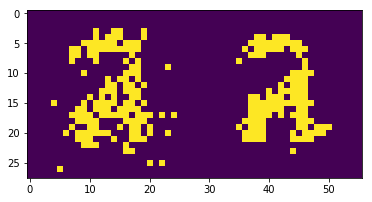

Starting batch: 369
Trained batch: 369


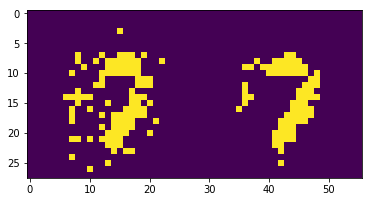

Starting batch: 370
Trained batch: 370


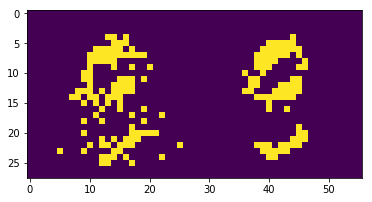

Starting batch: 371
Trained batch: 371


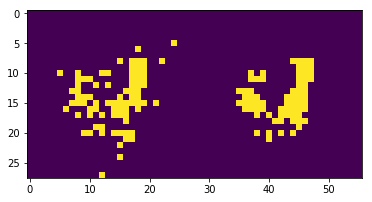

Starting batch: 372
Trained batch: 372


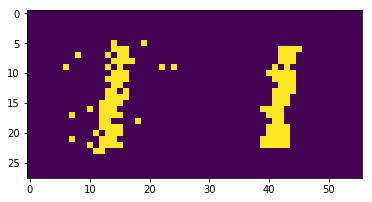

Starting batch: 373
Trained batch: 373


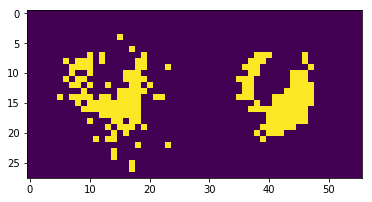

Starting batch: 374
Trained batch: 374


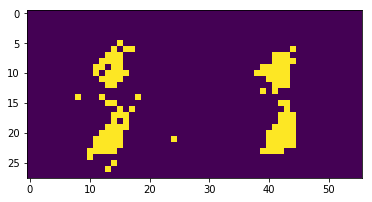

Starting batch: 375
Trained batch: 375


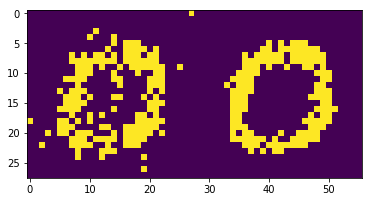

Starting batch: 376
Trained batch: 376


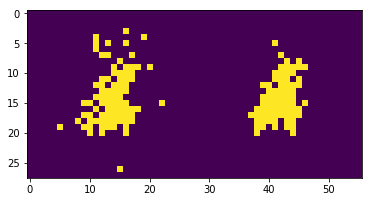

Starting batch: 377
Trained batch: 377


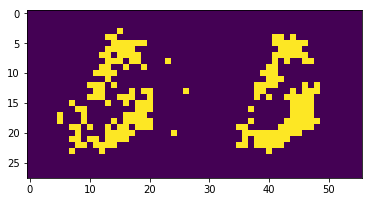

Starting batch: 378
Trained batch: 378


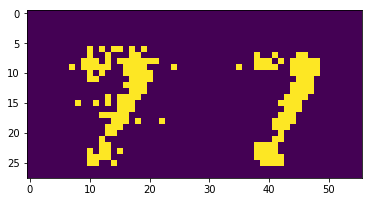

Starting batch: 379
Trained batch: 379


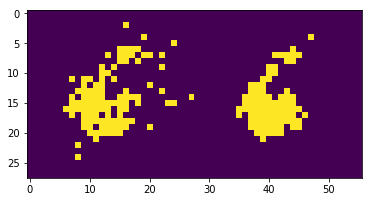

Starting batch: 380
Trained batch: 380


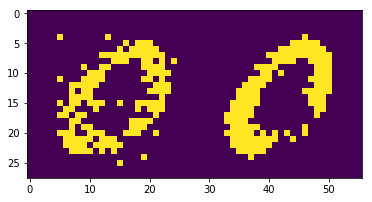

Starting batch: 381
Trained batch: 381


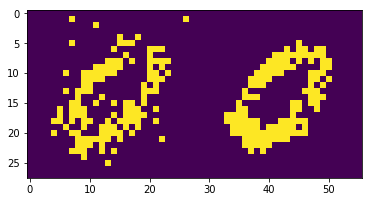

Starting batch: 382
Trained batch: 382


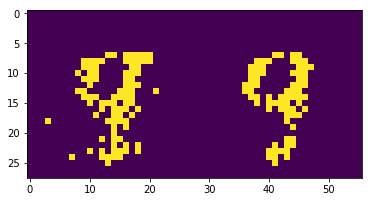

Starting batch: 383
Trained batch: 383


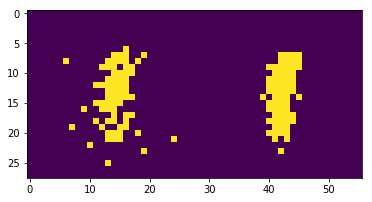

Starting batch: 384
Trained batch: 384


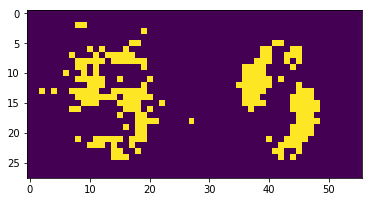

Starting batch: 385
Trained batch: 385


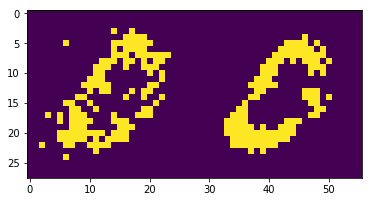

Starting batch: 386
Trained batch: 386


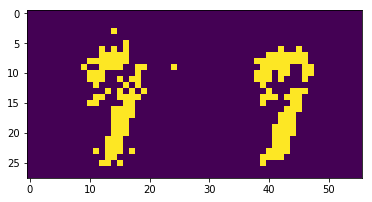

Starting batch: 387
Trained batch: 387


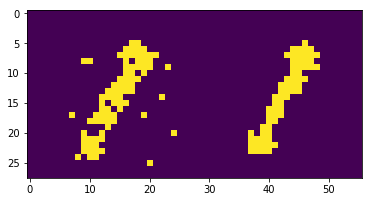

Starting batch: 388
Trained batch: 388


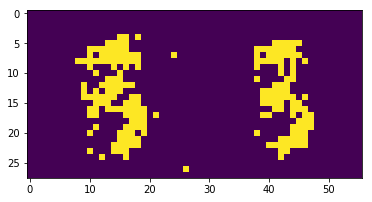

Starting batch: 389
Trained batch: 389


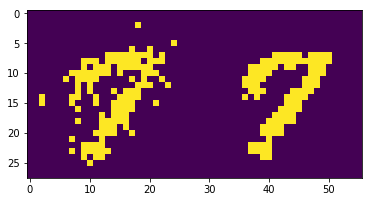

Starting batch: 390
Trained batch: 390


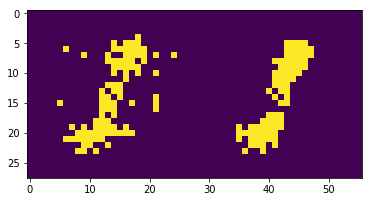

Starting batch: 391
Trained batch: 391


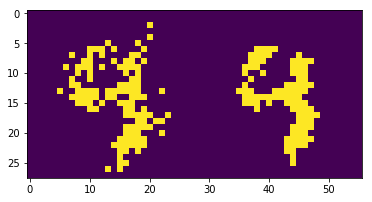

Starting batch: 392
Trained batch: 392


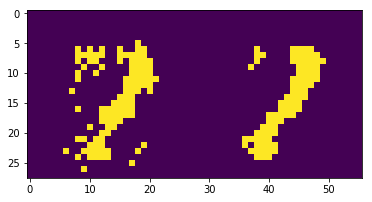

Starting batch: 393
Trained batch: 393


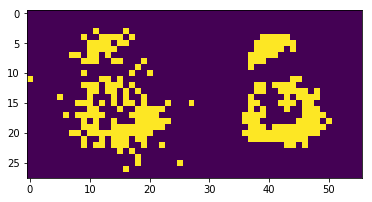

Starting batch: 394
Trained batch: 394


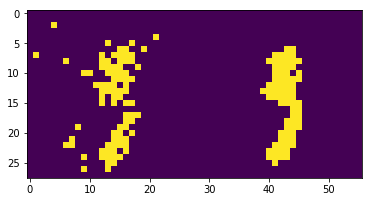

Starting batch: 395
Trained batch: 395


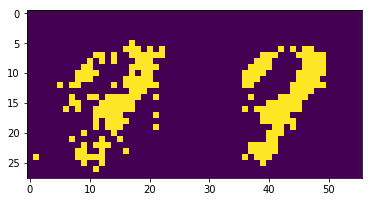

Starting batch: 396
Trained batch: 396


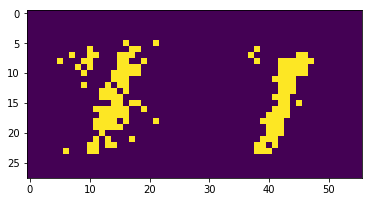

Starting batch: 397
Trained batch: 397


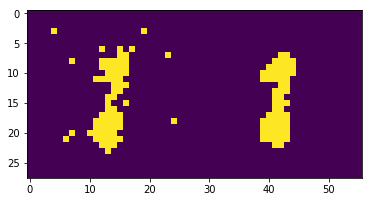

Starting batch: 398
Trained batch: 398


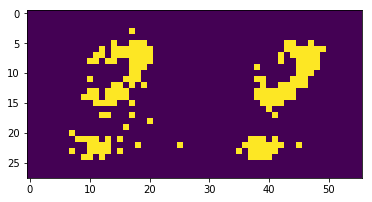

Starting batch: 399
Trained batch: 399


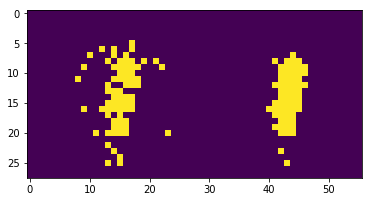

Starting batch: 400
Trained batch: 400


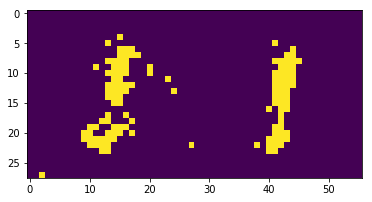

Starting batch: 401
Trained batch: 401


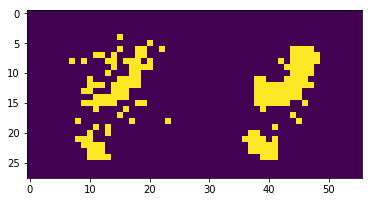

Starting batch: 402
Trained batch: 402


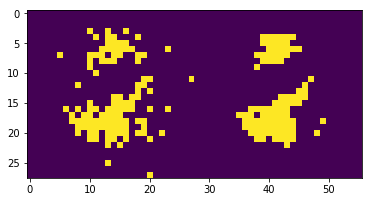

Starting batch: 403
Trained batch: 403


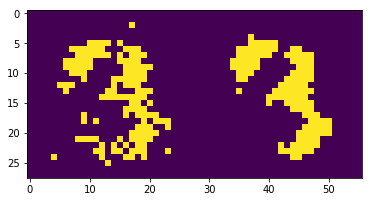

Starting batch: 404
Trained batch: 404


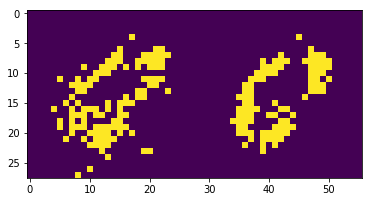

Starting batch: 405
Trained batch: 405


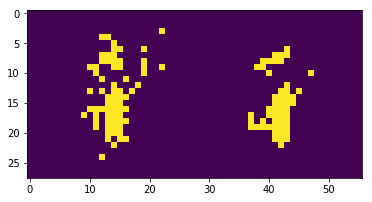

Starting batch: 406
Trained batch: 406


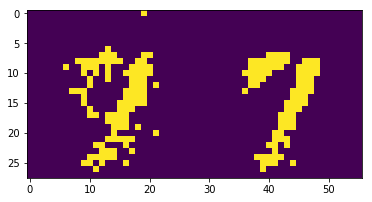

Starting batch: 407
Trained batch: 407


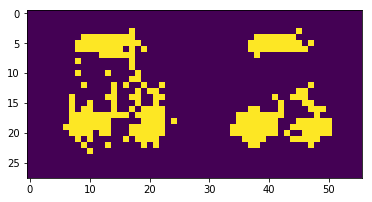

Starting batch: 408
Trained batch: 408


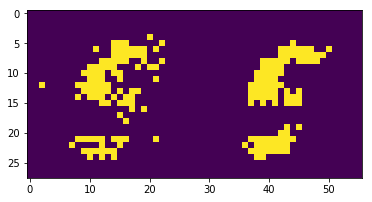

Starting batch: 409
Trained batch: 409


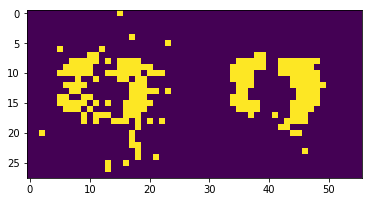

Starting batch: 410
Trained batch: 410


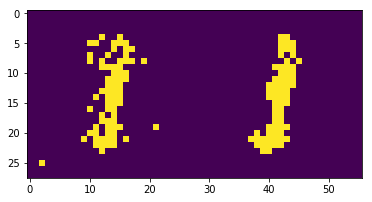

Starting batch: 411
Trained batch: 411


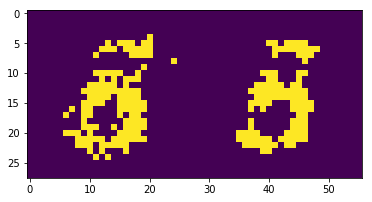

Starting batch: 412
Trained batch: 412


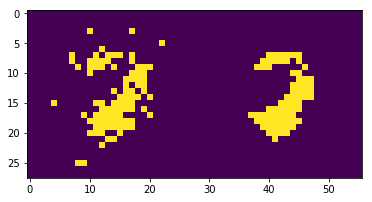

Starting batch: 413
Trained batch: 413


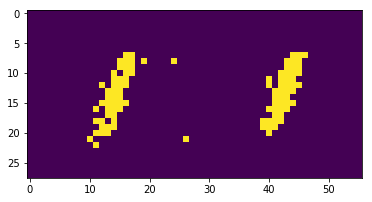

Starting batch: 414
Trained batch: 414


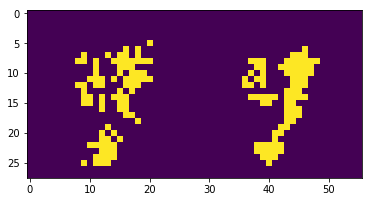

Starting batch: 415
Trained batch: 415


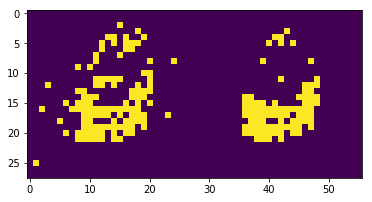

Starting batch: 416
Trained batch: 416


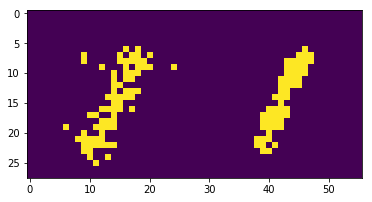

Starting batch: 417
Trained batch: 417


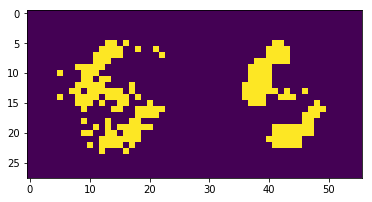

Starting batch: 418
Trained batch: 418


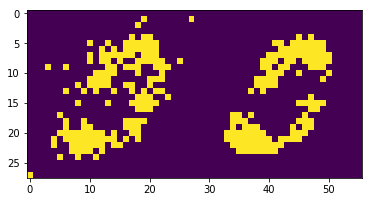

Starting batch: 419
Trained batch: 419


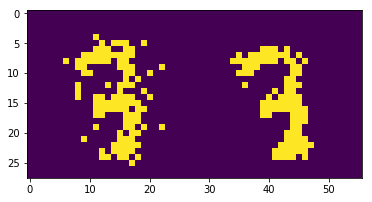

Starting batch: 420
Trained batch: 420


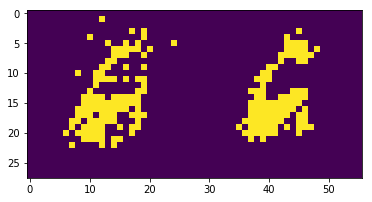

Starting batch: 421
Trained batch: 421


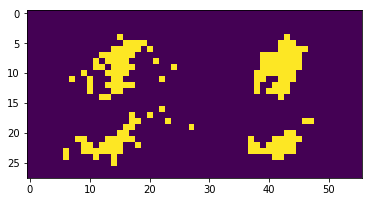

Starting batch: 422
Trained batch: 422


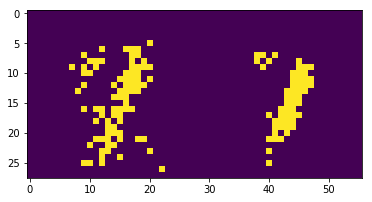

Starting batch: 423
Trained batch: 423


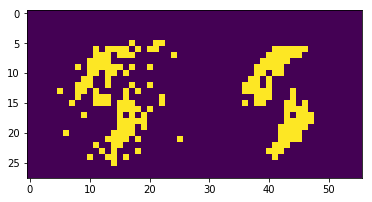

Starting batch: 424
Trained batch: 424


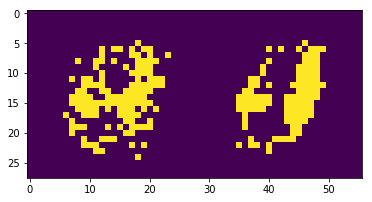

Starting batch: 425
Trained batch: 425


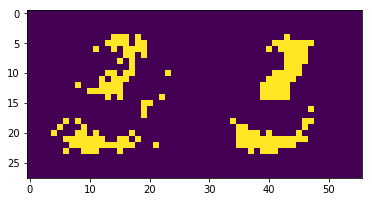

Starting batch: 426
Trained batch: 426


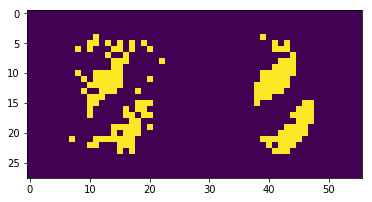

Starting batch: 427
Trained batch: 427


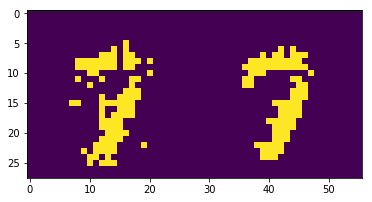

Starting batch: 428
Trained batch: 428


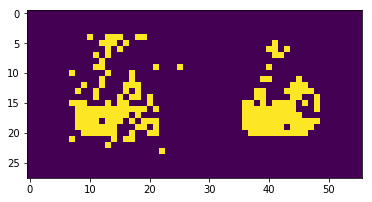

Starting batch: 429
Trained batch: 429


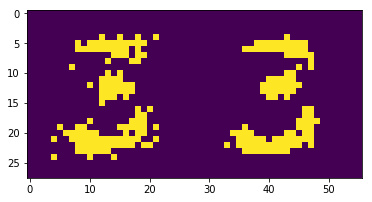

Starting batch: 430
Trained batch: 430


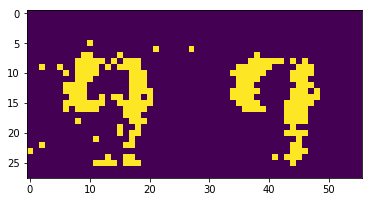

Starting batch: 431
Trained batch: 431


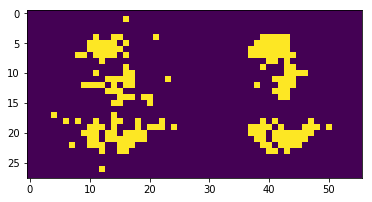

Starting batch: 432
Trained batch: 432


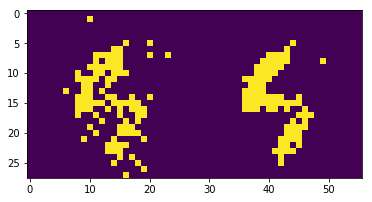

Starting batch: 433
Trained batch: 433


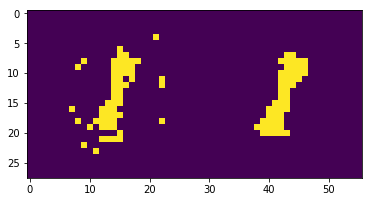

Starting batch: 434
Trained batch: 434


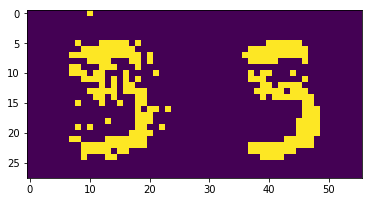

Starting batch: 435
Trained batch: 435


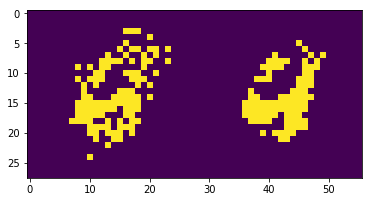

Starting batch: 436
Trained batch: 436


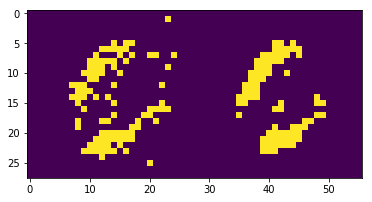

Starting batch: 437
Trained batch: 437


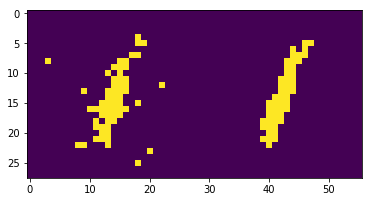

Starting batch: 438
Trained batch: 438


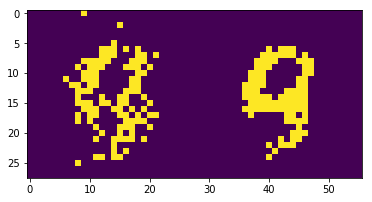

Starting batch: 439
Trained batch: 439


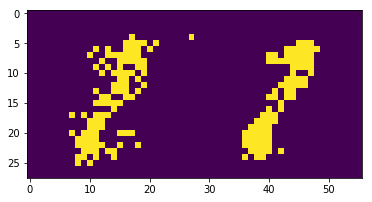

Starting batch: 440
Trained batch: 440


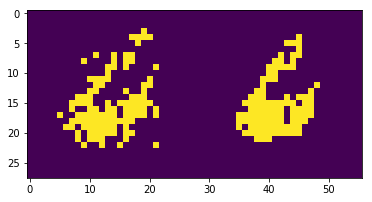

Starting batch: 441
Trained batch: 441


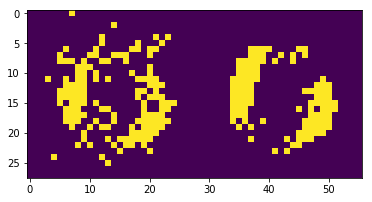

Starting batch: 442
Trained batch: 442


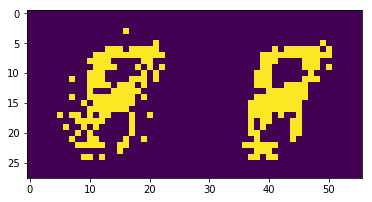

Starting batch: 443
Trained batch: 443


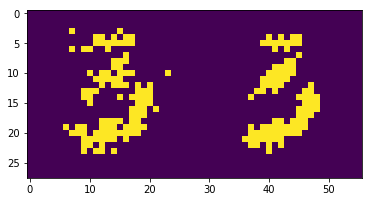

Starting batch: 444
Trained batch: 444


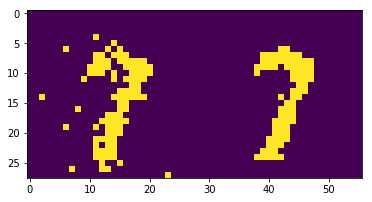

Starting batch: 445
Trained batch: 445


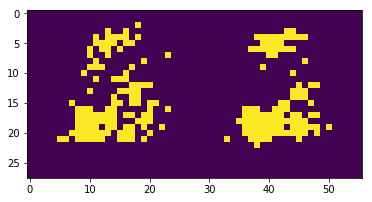

Starting batch: 446
Trained batch: 446


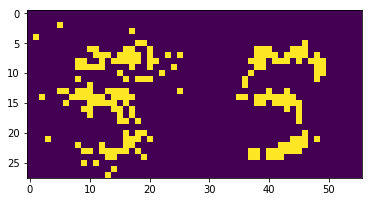

Starting batch: 447
Trained batch: 447


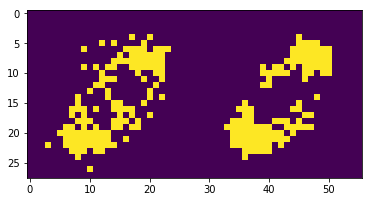

Starting batch: 448
Trained batch: 448


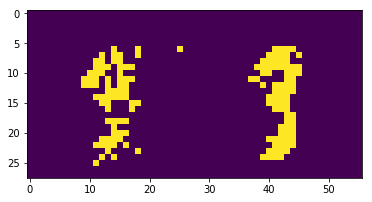

Starting batch: 449
Trained batch: 449


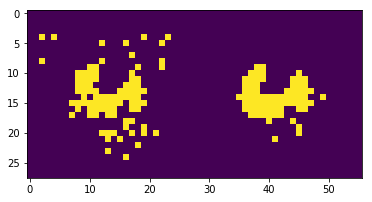

Starting batch: 450
Trained batch: 450


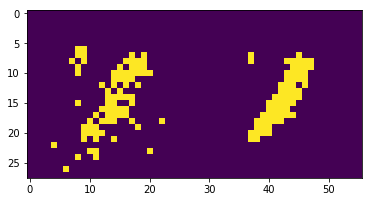

Starting batch: 451
Trained batch: 451


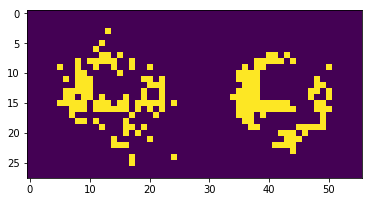

Starting batch: 452
Trained batch: 452


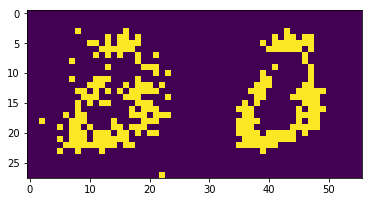

Starting batch: 453
Trained batch: 453


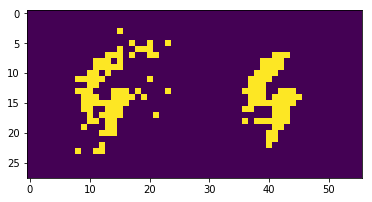

Starting batch: 454
Trained batch: 454


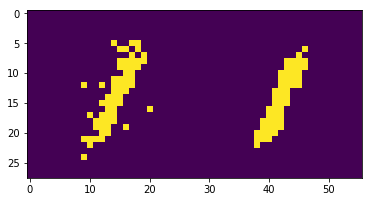

Starting batch: 455
Trained batch: 455


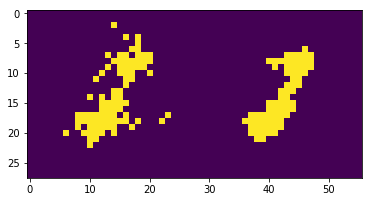

Starting batch: 456
Trained batch: 456


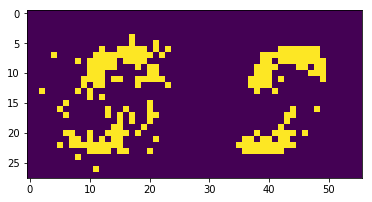

Starting batch: 457
Trained batch: 457


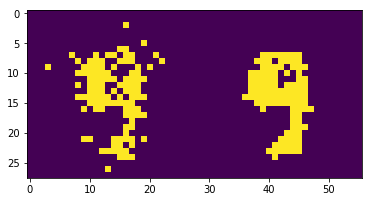

Starting batch: 458
Trained batch: 458


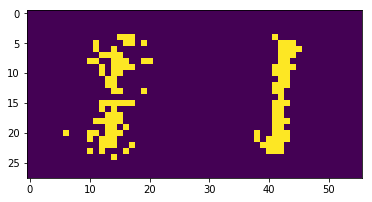

Starting batch: 459
Trained batch: 459


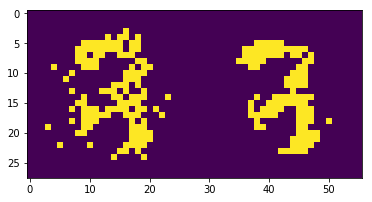

Starting batch: 460
Trained batch: 460


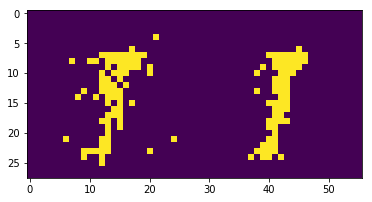

Starting batch: 461
Trained batch: 461


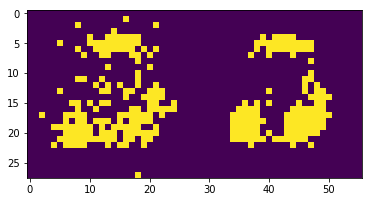

Starting batch: 462
Trained batch: 462


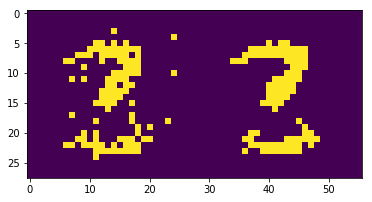

Starting batch: 463
Trained batch: 463


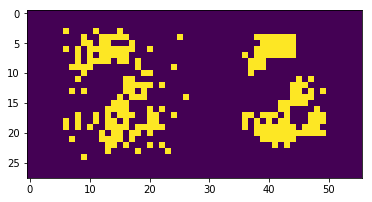

Starting batch: 464
Trained batch: 464


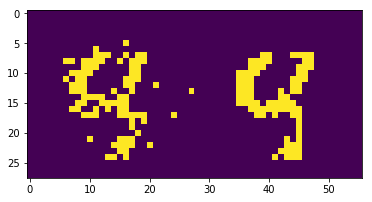

Starting batch: 465
Trained batch: 465


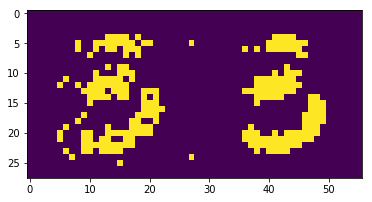

Starting batch: 466
Trained batch: 466


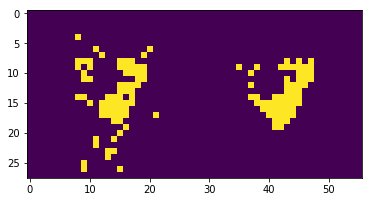

Starting batch: 467
Trained batch: 467


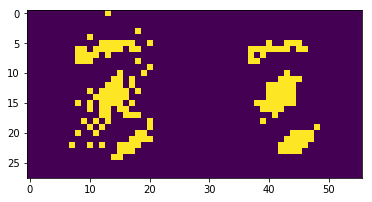

Starting batch: 468
Trained batch: 468


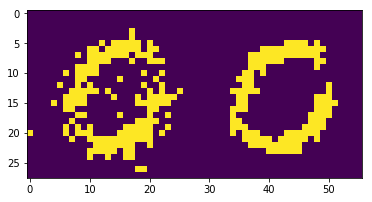

Starting batch: 469
Trained batch: 469


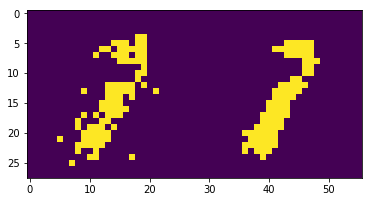

Starting batch: 470
Trained batch: 470


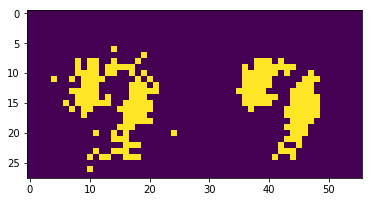

Starting batch: 471
Trained batch: 471


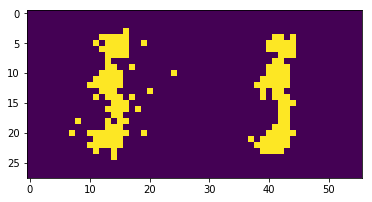

Starting batch: 472
Trained batch: 472


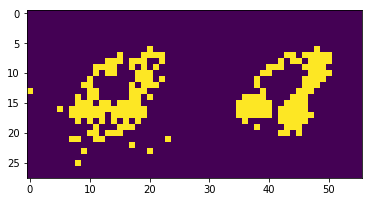

Starting batch: 473
Trained batch: 473


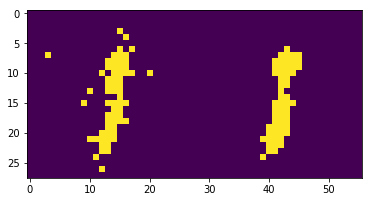

Starting batch: 474
Trained batch: 474


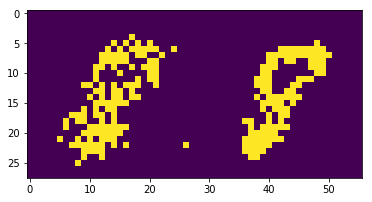

Starting batch: 475
Trained batch: 475


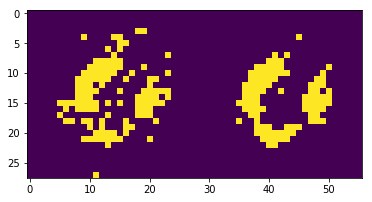

Starting batch: 476
Trained batch: 476


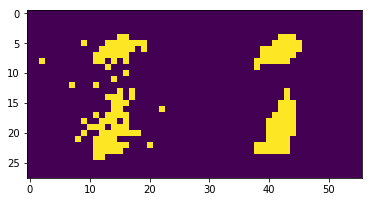

Starting batch: 477
Trained batch: 477


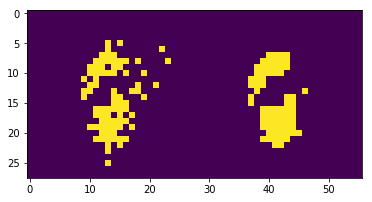

Starting batch: 478
Trained batch: 478


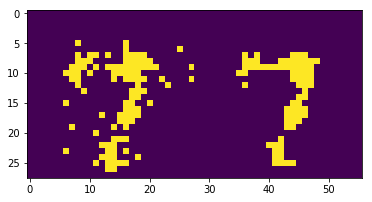

Starting batch: 479
Trained batch: 479


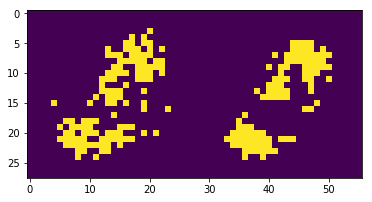

Starting batch: 480
Trained batch: 480


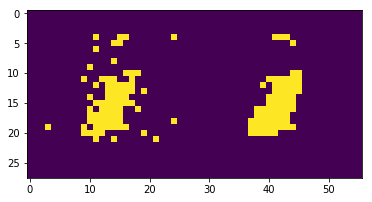

Starting batch: 481
Trained batch: 481


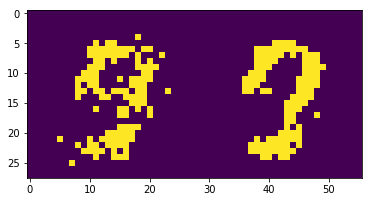

Starting batch: 482
Trained batch: 482


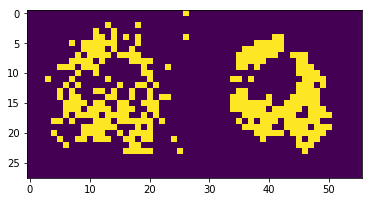

Starting batch: 483
Trained batch: 483


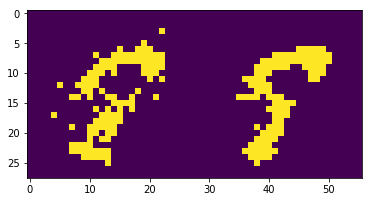

Starting batch: 484
Trained batch: 484


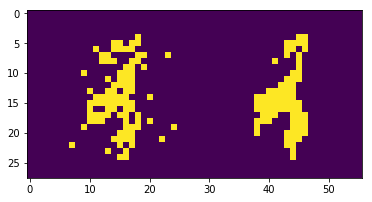

Starting batch: 485
Trained batch: 485


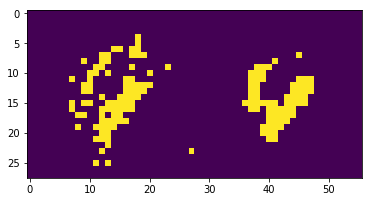

Starting batch: 486
Trained batch: 486


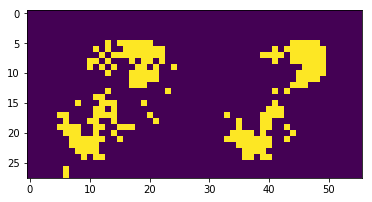

Starting batch: 487
Trained batch: 487


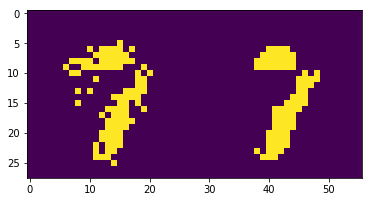

Starting batch: 488
Trained batch: 488


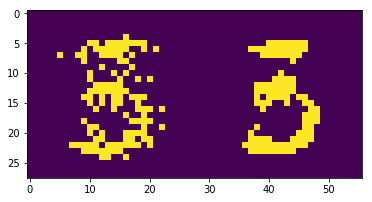

Starting batch: 489
Trained batch: 489


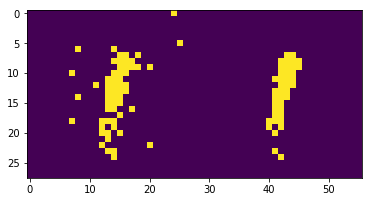

Starting batch: 490
Trained batch: 490


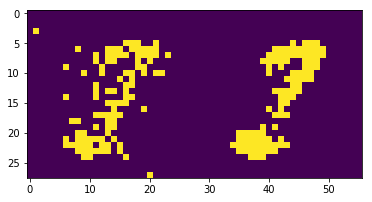

Starting batch: 491
Trained batch: 491


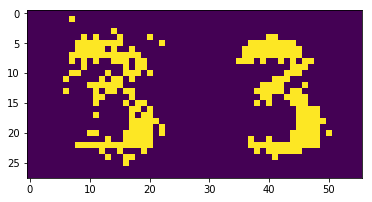

Starting batch: 492
Trained batch: 492


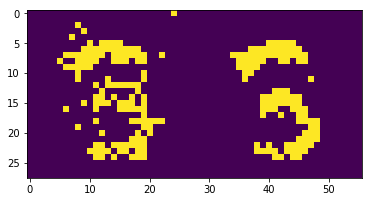

Starting batch: 493
Trained batch: 493


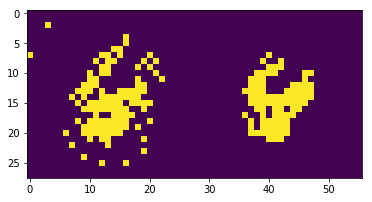

Starting batch: 494
Trained batch: 494


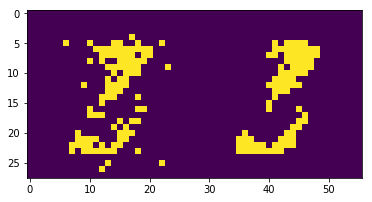

Starting batch: 495
Trained batch: 495


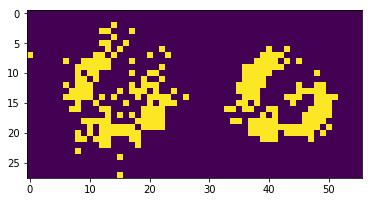

Starting batch: 496
Trained batch: 496


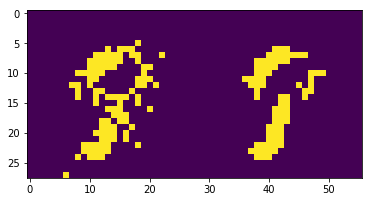

Starting batch: 497
Trained batch: 497


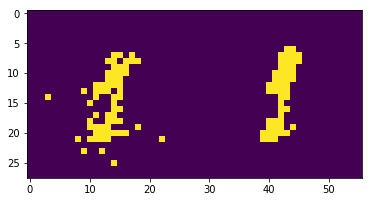

Starting batch: 498
Trained batch: 498


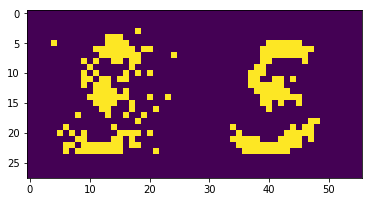

Starting batch: 499
Trained batch: 499


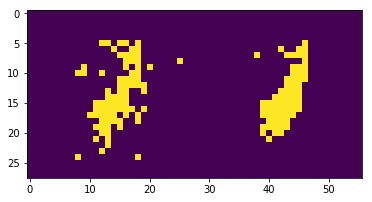

Starting batch: 500
Trained batch: 500


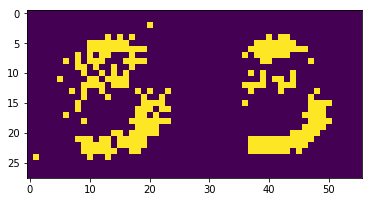

Starting batch: 501
Trained batch: 501


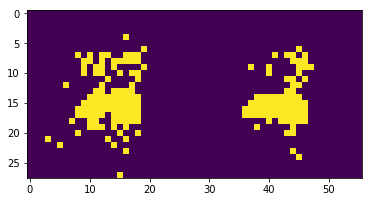

Starting batch: 502
Trained batch: 502


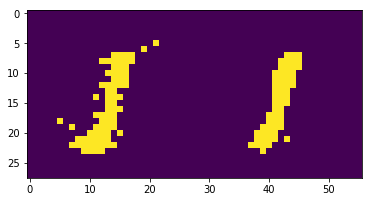

Starting batch: 503
Trained batch: 503


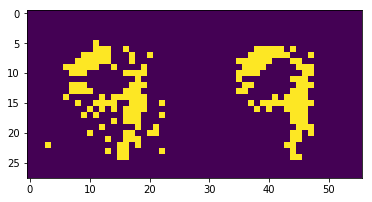

Starting batch: 504
Trained batch: 504


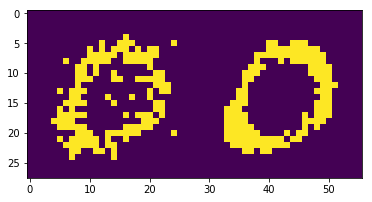

Starting batch: 505
Trained batch: 505


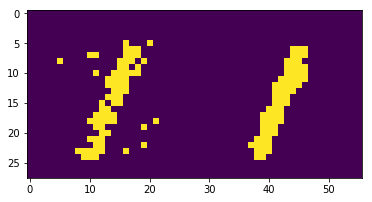

Starting batch: 506
Trained batch: 506


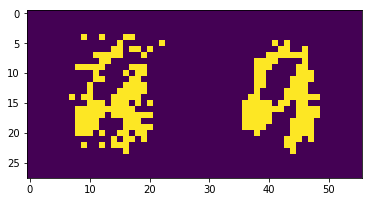

Starting batch: 507
Trained batch: 507


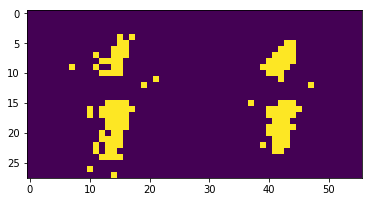

Starting batch: 508
Trained batch: 508


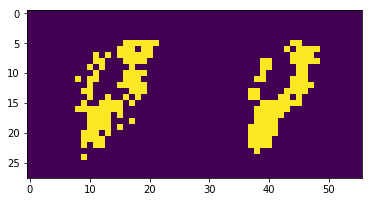

Starting batch: 509
Trained batch: 509


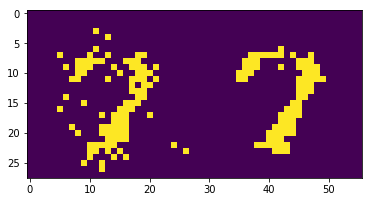

Starting batch: 510
Trained batch: 510


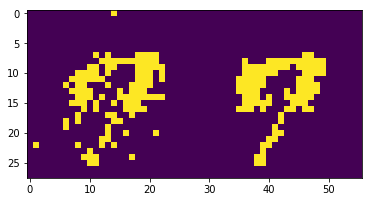

Starting batch: 511
Trained batch: 511


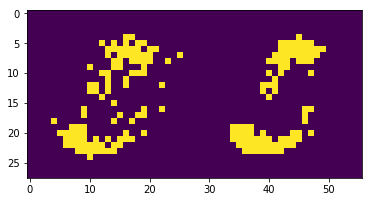

Starting batch: 512
Trained batch: 512


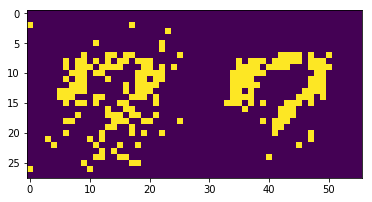

Starting batch: 513
Trained batch: 513


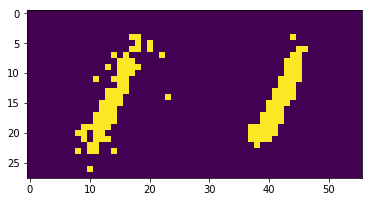

Starting batch: 514
Trained batch: 514


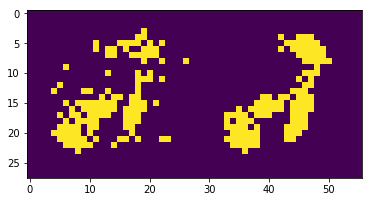

Starting batch: 515
Trained batch: 515


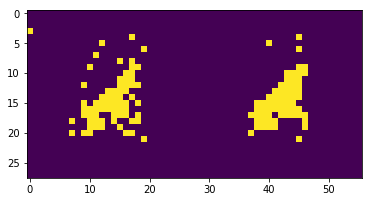

Starting batch: 516
Trained batch: 516


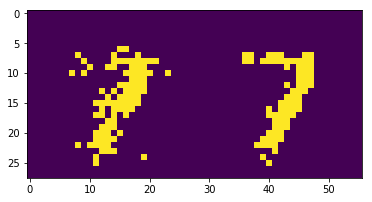

Starting batch: 517
Trained batch: 517


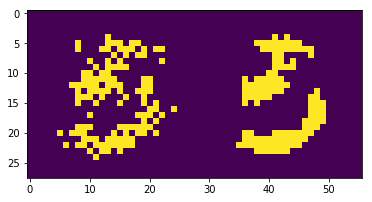

Starting batch: 518
Trained batch: 518


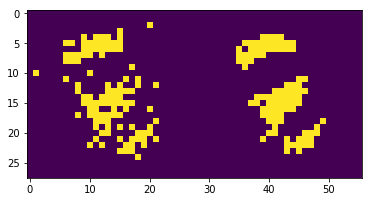

Starting batch: 519
Trained batch: 519


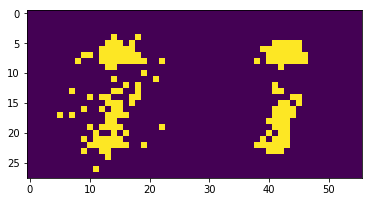

Starting batch: 520
Trained batch: 520


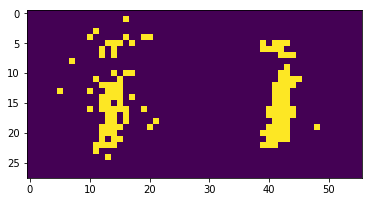

Starting batch: 521
Trained batch: 521


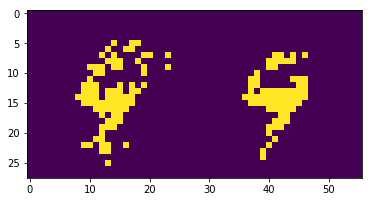

Starting batch: 522
Trained batch: 522


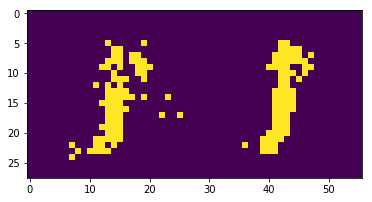

Starting batch: 523
Trained batch: 523


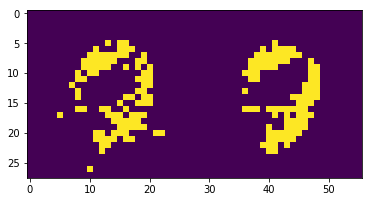

Starting batch: 524
Trained batch: 524


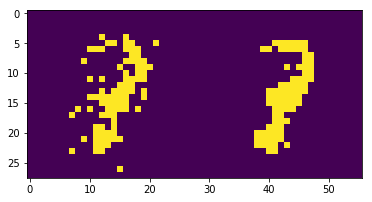

Starting batch: 525
Trained batch: 525


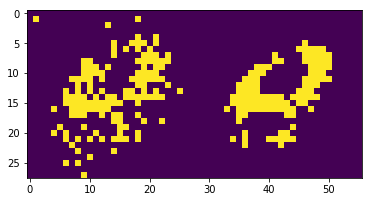

Starting batch: 526
Trained batch: 526


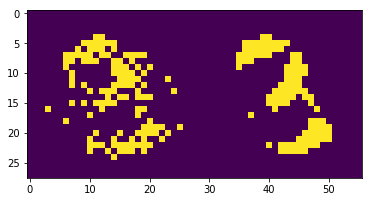

Starting batch: 527
Trained batch: 527


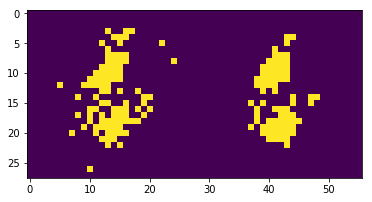

Starting batch: 528
Trained batch: 528


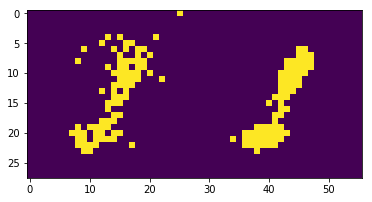

Starting batch: 529
Trained batch: 529


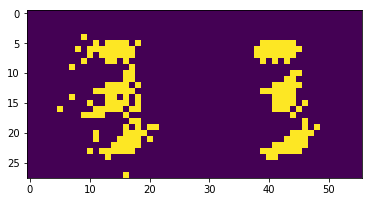

Starting batch: 530
Trained batch: 530


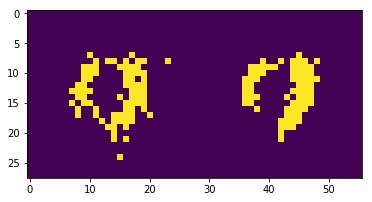

Starting batch: 531
Trained batch: 531


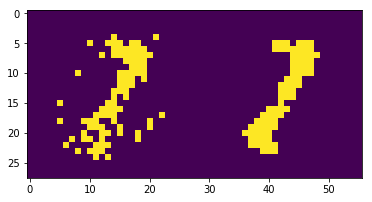

Starting batch: 532
Trained batch: 532


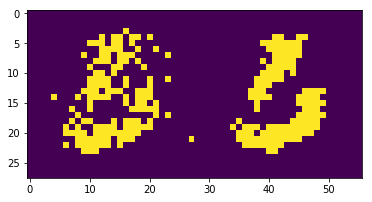

Starting batch: 533
Trained batch: 533


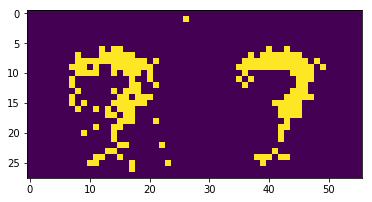

Starting batch: 534
Trained batch: 534


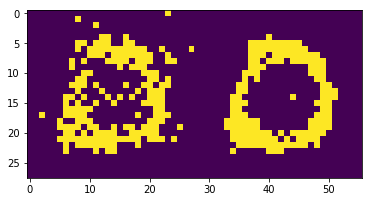

Starting batch: 535
Trained batch: 535


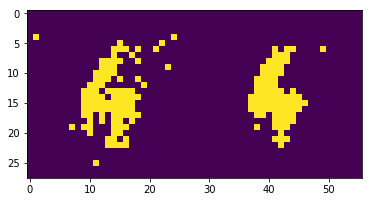

Starting batch: 536
Trained batch: 536


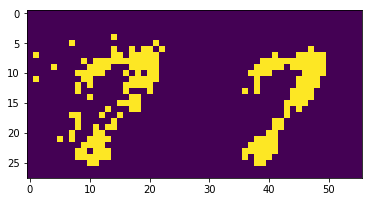

Starting batch: 537
Trained batch: 537


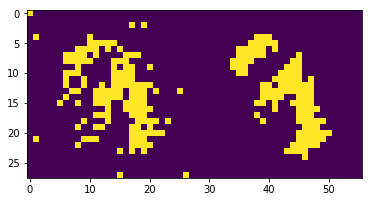

Starting batch: 538
Trained batch: 538


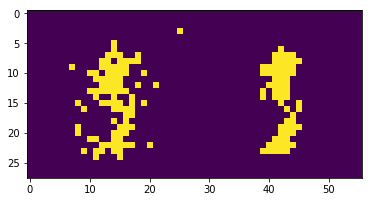

Starting batch: 539
Trained batch: 539


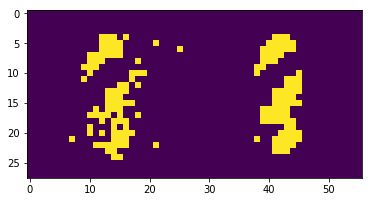

Starting batch: 540
Trained batch: 540


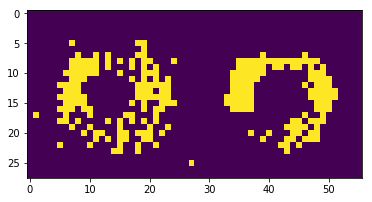

Starting batch: 541
Trained batch: 541


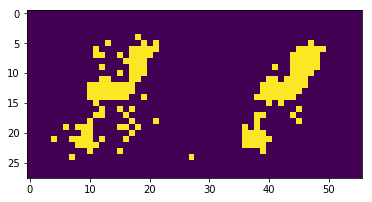

Starting batch: 542
Trained batch: 542


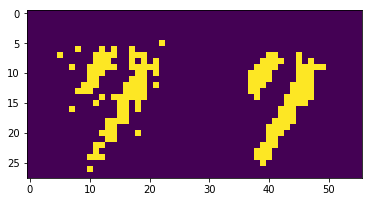

Starting batch: 543
Trained batch: 543


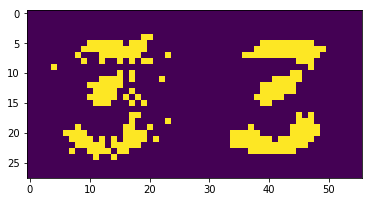

Starting batch: 544
Trained batch: 544


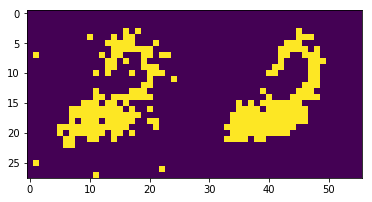

Starting batch: 545
Trained batch: 545


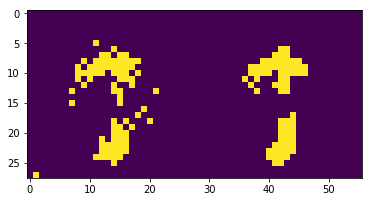

Starting batch: 546
Trained batch: 546


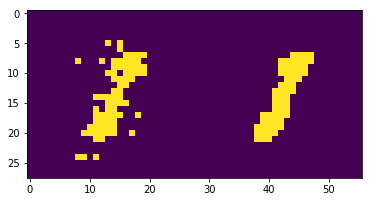

Starting batch: 547
Trained batch: 547


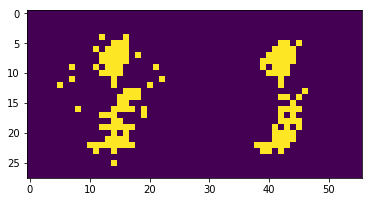

Starting batch: 548
Trained batch: 548


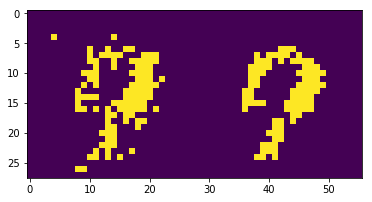

Starting batch: 549
Trained batch: 549


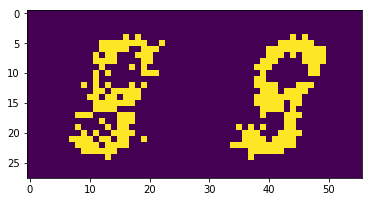

Starting batch: 550
Trained batch: 550


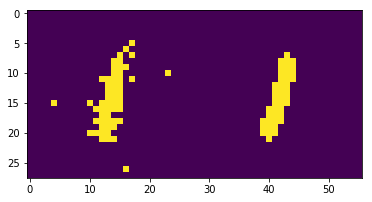

Starting batch: 551
Trained batch: 551


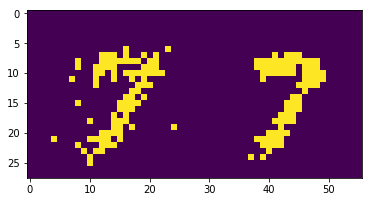

Starting batch: 552
Trained batch: 552


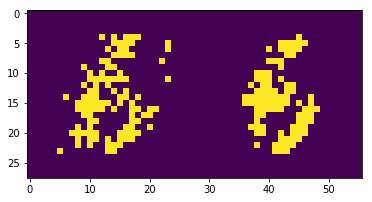

Starting batch: 553
Trained batch: 553


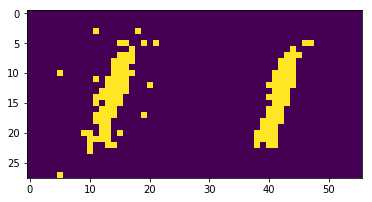

Starting batch: 554
Trained batch: 554


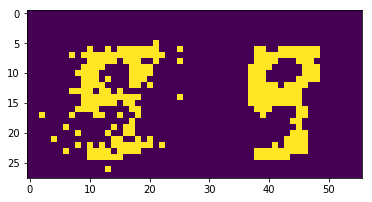

Starting batch: 555
Trained batch: 555


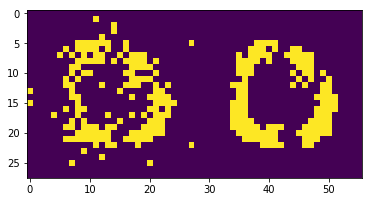

Starting batch: 556
Trained batch: 556


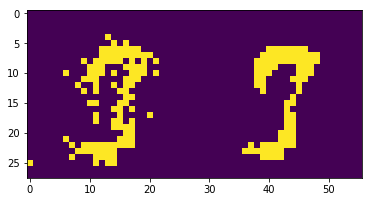

Starting batch: 557
Trained batch: 557


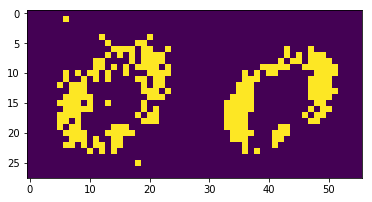

Starting batch: 558
Trained batch: 558


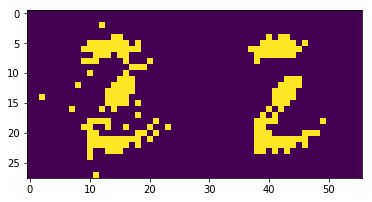

Starting batch: 559
Trained batch: 559


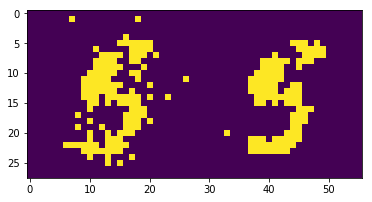

Starting batch: 560
Trained batch: 560


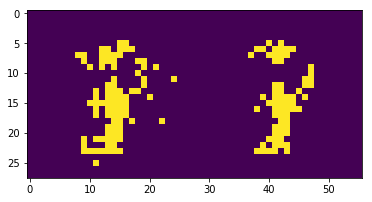

Starting batch: 561
Trained batch: 561


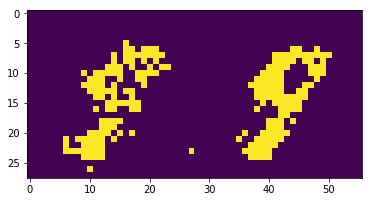

Starting batch: 562
Trained batch: 562


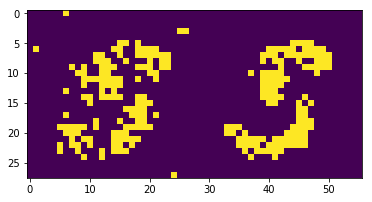

Starting batch: 563
Trained batch: 563


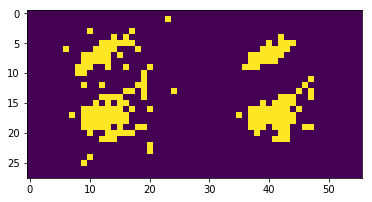

Starting batch: 564
Trained batch: 564


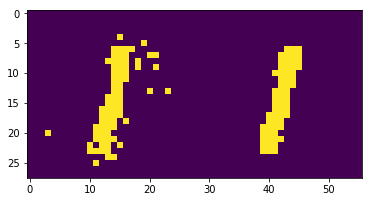

Starting batch: 565
Trained batch: 565


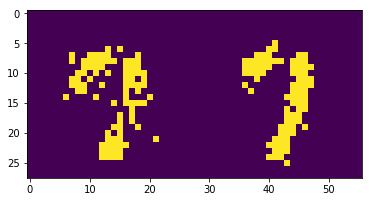

Starting batch: 566
Trained batch: 566


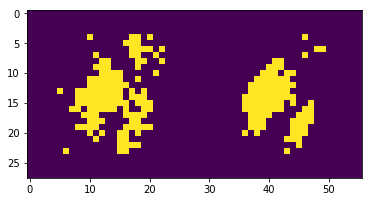

Starting batch: 567
Trained batch: 567


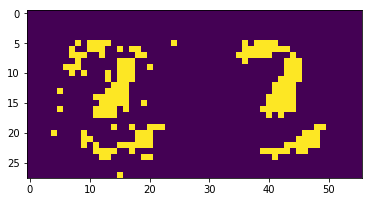

Starting batch: 568
Trained batch: 568


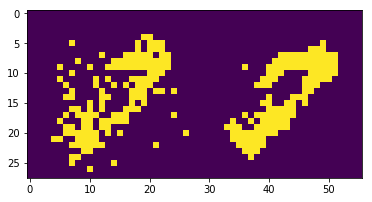

Starting batch: 569
Trained batch: 569


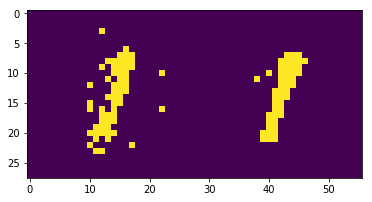

Starting batch: 570
Trained batch: 570


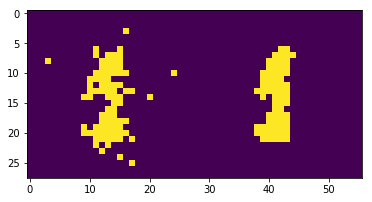

Starting batch: 571
Trained batch: 571


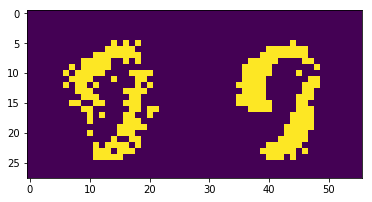

Starting batch: 572
Trained batch: 572


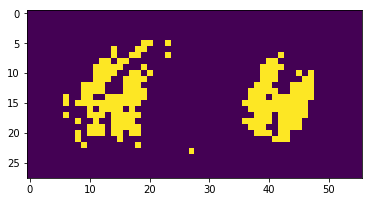

Starting batch: 573
Trained batch: 573


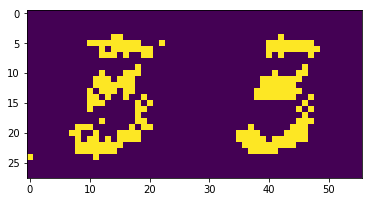

Starting batch: 574
Trained batch: 574


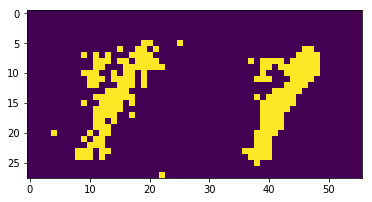

Starting batch: 575
Trained batch: 575


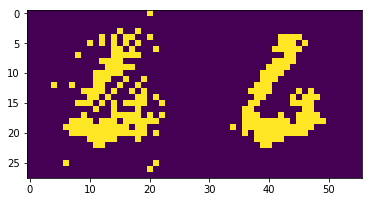

Starting batch: 576
Trained batch: 576


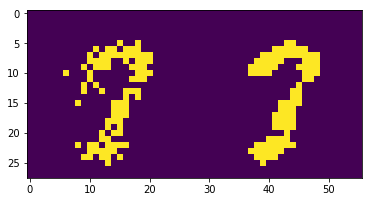

Starting batch: 577
Trained batch: 577


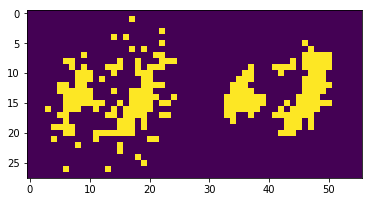

Starting batch: 578
Trained batch: 578


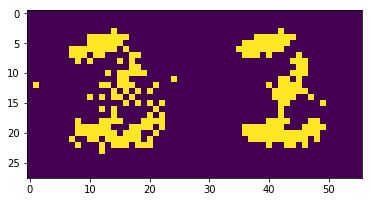

Starting batch: 579
Trained batch: 579


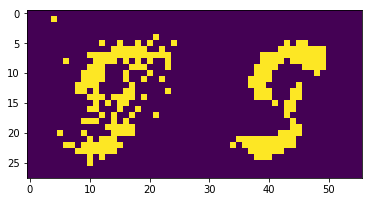

Starting batch: 580
Trained batch: 580


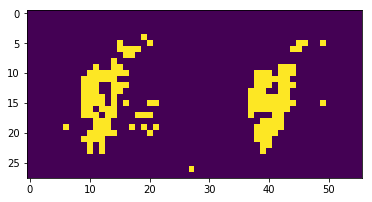

Starting batch: 581
Trained batch: 581


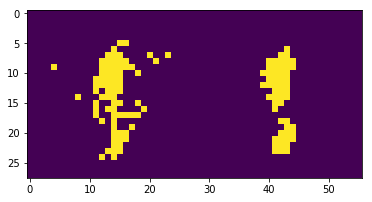

Starting batch: 582
Trained batch: 582


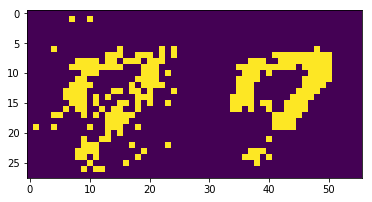

Starting batch: 583
Trained batch: 583


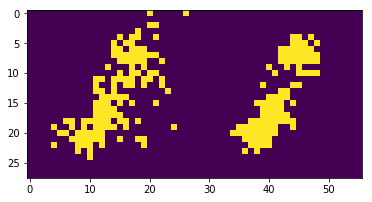

Starting batch: 584
Trained batch: 584


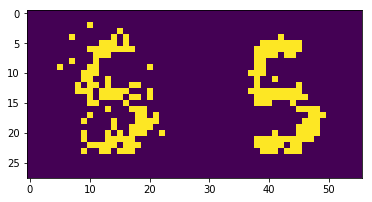

Starting batch: 585
Trained batch: 585


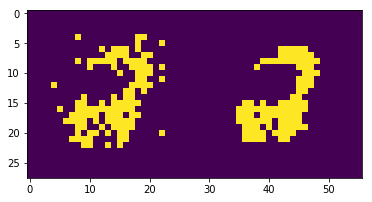

Starting batch: 586
Trained batch: 586


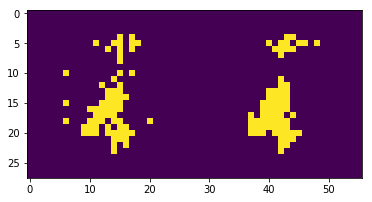

Starting batch: 587
Trained batch: 587


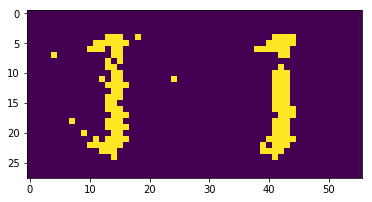

Starting batch: 588
Trained batch: 588


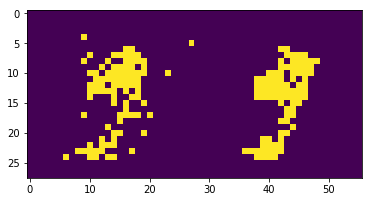

Starting batch: 589
Trained batch: 589


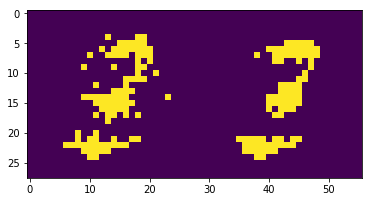

Starting batch: 590
Trained batch: 590


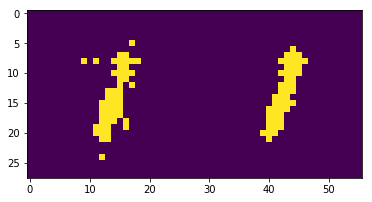

Starting batch: 591
Trained batch: 591


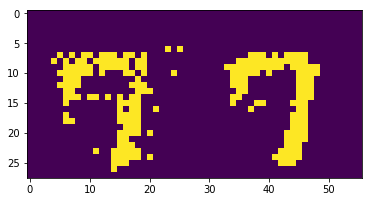

Starting batch: 592
Trained batch: 592


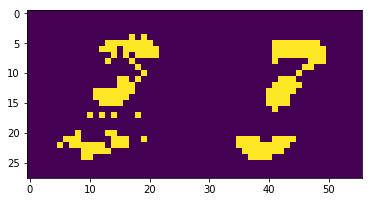

Starting batch: 593
Trained batch: 593


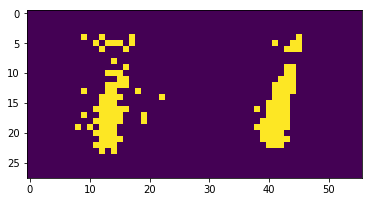

Starting batch: 594
Trained batch: 594


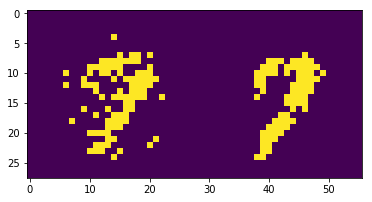

Starting batch: 595
Trained batch: 595


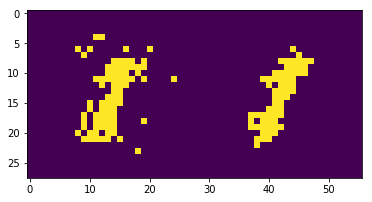

Starting batch: 596
Trained batch: 596


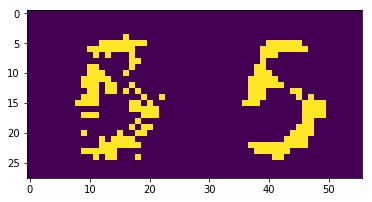

Starting batch: 597
Trained batch: 597


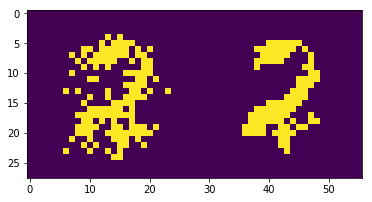

Starting batch: 598
Trained batch: 598


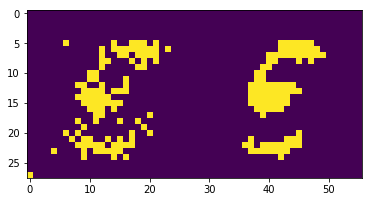

Starting batch: 599
Trained batch: 599


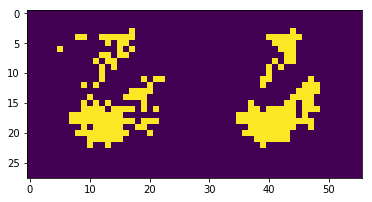

Starting batch: 600
Trained batch: 600


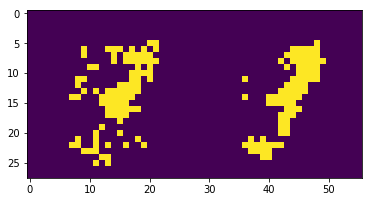

Starting batch: 601
Trained batch: 601


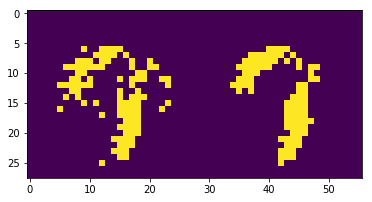

Starting batch: 602
Trained batch: 602


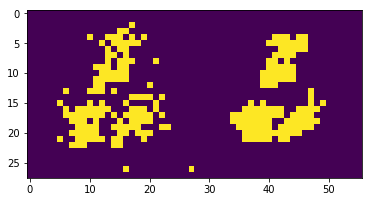

Starting batch: 603
Trained batch: 603


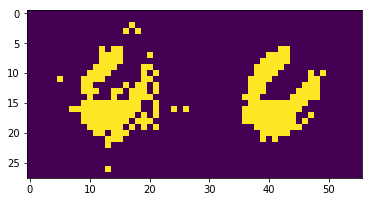

Starting batch: 604
Trained batch: 604


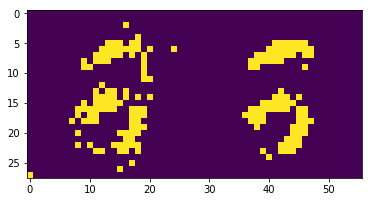

Starting batch: 605
Trained batch: 605


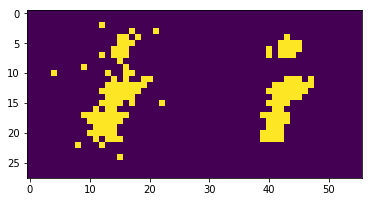

Starting batch: 606
Trained batch: 606


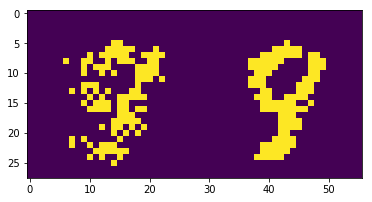

Starting batch: 607
Trained batch: 607


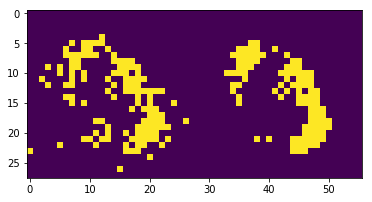

Starting batch: 608
Trained batch: 608


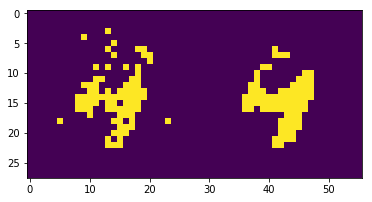

Starting batch: 609
Trained batch: 609


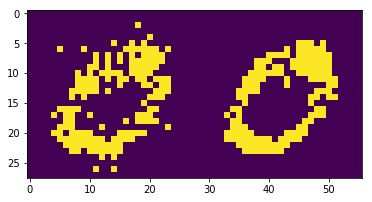

Starting batch: 610
Trained batch: 610


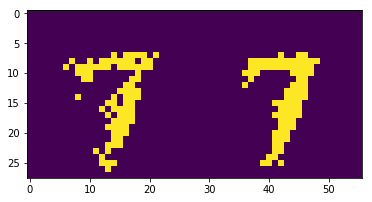

Starting batch: 611
Trained batch: 611


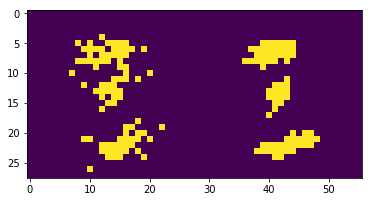

Starting batch: 612
Trained batch: 612


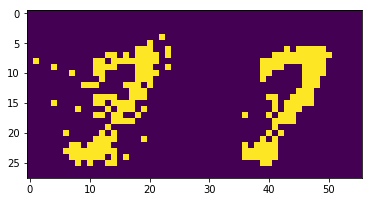

Starting batch: 613
Trained batch: 613


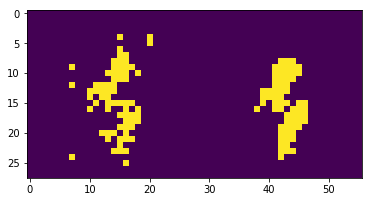

Starting batch: 614
Trained batch: 614


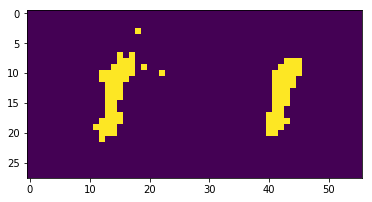

Starting batch: 615
Trained batch: 615


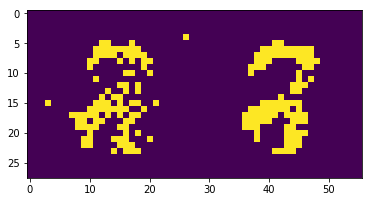

Starting batch: 616
Trained batch: 616


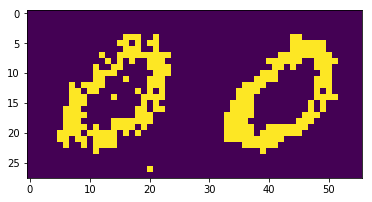

Starting batch: 617
Trained batch: 617


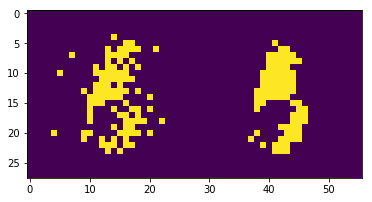

Starting batch: 618
Trained batch: 618


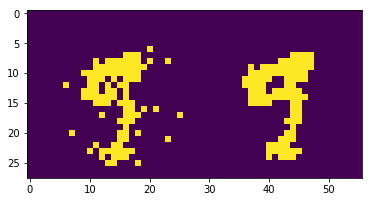

Starting batch: 619


KeyboardInterrupt: 

In [152]:
figure_no = 0
for i in range(1000):
    print 'Starting batch:', i+1
    rbm_persistent.train(num_iters_gibbs=100, num_iters_exp=10)
    print 'Trained batch:', i+1
    v, h = rbm_persistent.sample(num_iters=100)
    v_argmax = (rbm_persistent.prob_v_given_h(h) >= 0.5).astype(np.float32)
    plt.imshow(np.concatenate([v.reshape((28, 28)), v_argmax.reshape((28, 28))], axis=1))
    plt.show()

In [153]:
images = mnist_persistent.get_batch()

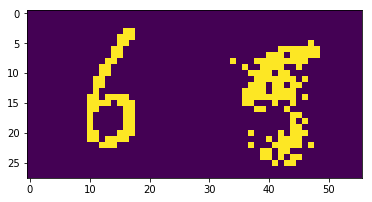

In [176]:
idx = 23
v = images[idx, :].transpose()
h = rbm_persistent.prob_h_given_v(v)
h = np.random.binomial(1, p=h).astype(np.float32)
v_recon = rbm_persistent.prob_v_given_h(h)
v_recon = np.random.binomial(1, v_recon).astype(np.float32)
v_recon, _ = rbm_persistent.sample(h=h)
plt.imshow(np.concatenate([v.reshape((28, 28)), v_recon.reshape((28, 28))], axis=1))

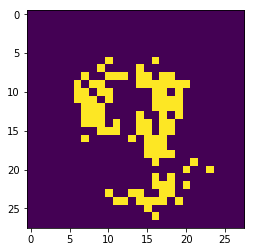

In [182]:
v, h = rbm_persistent.sample(num_iters=1500)
plt.imshow((v.reshape((28, 28)) >= 0.5).astype(np.float32))